In [1]:
%matplotlib inline

import numpy as np
import math
import os
import matplotlib
import matplotlib.pyplot as plt
import librosa as lb
import librosa.display as lbd
import IPython.display as ipd
import scipy.signal as ss
import scipy.spatial as sspat
import scipy.fft as sfft
import warnings
import pickle as pkl
import time
import itertools

In [2]:
%cd ../
import CythonDTW
import TSM_Import

/home/krong/Documents/classes/SP/final/AdaptiveAccompaniment


In [3]:
hop_length = 512

In [4]:
fileId_path = "experiments/fileIds.pkl"
queryInfo_path = "experiments/queryInfo.pkl"
timeData_path = "experiments/timeData.pkl"
audioFiles_path = "experiments/audioFiles.pkl"
with open(fileId_path, 'rb') as f:
    fileIds=pkl.load(f)
with open(queryInfo_path, 'rb') as f:
    queryInfo=pkl.load(f)
with open(timeData_path, 'rb') as f:
    timeData=pkl.load(f)
with open(audioFiles_path, 'rb') as f:
    audioFiles=pkl.load(f)

In [5]:
sr = 22050

In [6]:
def getChromaFeatures(audio):
    chroma = lb.feature.chroma_stft(audio, norm=2)
    return chroma

In [7]:
def subsequencialDTW(cost_matrix):
    steps = np.array([2, 1, 1, 2, 1, 1]).reshape((3,2))
    weights = [2,1,1]
    D,wp = lb.sequence.dtw(C=cost_matrix, step_sizes_sigma=steps, weights_mul=weights, subseq=True, backtrack=True)
    return D,wp

In [8]:
def getCostMatrix(query, ref):
    return sspat.distance.cdist(query.T, ref.T, metric='cosine')

In [9]:
def inverse_time_function(wp):
    wp = wp*512
    output = np.zeros((wp[-1,0])+1)
    for pair_index in range(len(wp)-1):
        x_0 = wp[pair_index,0]
        x_1 = wp[pair_index+1,0]
        y_0 = wp[pair_index,1]
        y_1 = wp[pair_index+1,1]
        slope = (y_1-y_0)/(x_1-x_0)
        array = y_0+np.arange(x_1-x_0)*slope
        output[x_0:x_1] =array.astype(int)
    output[-1] = wp[-1,1]
    return output

In [10]:
def tf_preprocessing(local_paths):
    ls = []
    for seg in local_paths:
        new_seg = []
        for pair in seg:
            new_seg.append(np.array([pair[0],pair[1]]))
        ls.append(np.array(new_seg))
    return ls
def seg_time_function(wp):
    start_time  = time.time()
    wp = wp*hop_length
    output = np.zeros((wp[-1,1]-wp[0,1])+1)
    x_b = wp[0,1]
    for pair_index in range(len(wp)-1):
        y_0 = wp[pair_index,0]
        y_1 = wp[pair_index+1,0]
        x_0 = wp[pair_index,1]
        x_1 = wp[pair_index+1,1]
        slope = (y_1-y_0)/(x_1-x_0)
        array = y_0+np.arange(x_1-x_0)*slope
        output[x_0-x_b:x_1-x_b] = array
    output[-1] = wp[-1,0]

    return output
def group_time_function(wp,ref_audio_len):
    wp = tf_preprocessing(wp)
    start_time = time.time()

    output = np.zeros(ref_audio_len)
    

    current_start = 0
    for index, seg_path in enumerate(wp):

        pre_padd_end = seg_path[0][1] * hop_length

        output[current_start:pre_padd_end]=(np.arange(pre_padd_end-current_start)+1)+output[current_start-1]

        current_start = pre_padd_end
        tf = seg_time_function(seg_path)
        if index > 0:
            start_point = max(0,wp[index-1][-1][1]-wp[index][0][1])*hop_length
            end_point = min(len(output)-current_start,len(tf))

            tf = tf[start_point:end_point]

        if len(tf)>=2:
            output[current_start:current_start+len(tf)] = tf+tf[1]+output[current_start-1]
        elif len(tf)==1:
            output[current_start:current_start+len(tf)] = tf+output[current_start-1]
        current_start = current_start+len(tf)

    output[current_start:]=np.arange(ref_audio_len-current_start)+output[current_start-1]
    return output

In [11]:
def realTimeAccompaniment(new_input,stored_info,evaluate, sim):
    #prior = stored_info['prior']
    orchestra_chroma = stored_info['orchestra_chroma']
    '''
    audio_input = np.zeros((len(new_input)+len(prior)))
    if len(prior)>0:
        audio_input[:len(prior)]=prior
        audio_input[len(prior):]=new_input
    else:
        audio_input=new_input
    '''

    orchestra_audio = stored_info['orchestra_audio']
    input_chroma = getChromaFeatures(new_input)
    cost_matrix = getCostMatrix(input_chroma, orchestra_chroma)
    D,wp = subsequencialDTW(cost_matrix)
    wp = np.sort(wp,axis=0)
    tf, itf, audio_output = [], [], []
    if evaluate:
        tf = group_time_function([wp],len(orchestra_audio))
    if sim:
        itf = inverse_time_function(wp)
        audio_output = TSM_Import.phase_vocoder(orchestra_audio, (itf).astype(int))
    
    #stored_info['prior'].append(new_input)
    return audio_output, tf, stored_info

In [12]:
def realTimeSim(soloist, orchestra, sr = 22050):
    stored_info = dict()
    accompanyment = []
    orchestra_chroma = getChromaFeatures(orchestra)
    stored_info["orchestra_chroma"]=orchestra_chroma 
    stored_info['orchestra_audio'] = orchestra
    for solo_seg in soloist:
        accompanyment_seg = np.zeros(len(solo_seg))
        #stored_info['prior'] = []
        current_seconds = 0
        input_length_sec = .023*100
        input_length_frame = input_length_sec*sr
        num_input = int(np.ceil(len(solo_seg)/input_length_frame))
        for input_index in range(num_input):
            audio_input = solo_seg[int(input_index*input_length_frame):int((input_index+1)*input_length_frame)]
            start_time = time.time()
            audio_output, time_function_output, stored_info = realTimeAccompaniment(audio_input,stored_info,False, True)
            
            time_offset = time.time()-start_time
            print(time_offset)
            start_point = int(input_index*input_length_frame+time_offset)
            if start_point+len(audio_output)<len(accompanyment_seg):
                accompanyment_seg[start_point:start_point+len(audio_output)]=audio_output
            else:
                accompanyment_seg[start_point:]=audio_output[:len(accompanyment_seg)-start_point]
        accompanyment.append(accompanyment_seg)
    return accompanyment

In [32]:
soloist = audioFiles["p1s_perf12"]
orchestra = audioFiles["p1f_perf16"]
accompanyment = realTimeSim(soloist,orchestra)

/home/krong/Documents/classes/SP/final/AdaptiveAccompaniment/src/TSM_Import.py:128: ComplexWarning: Casting complex values to real discards the imaginary part
  spectrogram[:,index]= spec


w nom (1025, 1) hop (98,) S (1025, 98) analysis_instances (99,) S[0] (98,)
0.2548060417175293
w nom (1025, 1) hop (98,) S (1025, 98) analysis_instances (99,) S[0] (98,)
0.10673379898071289
w nom (1025, 1) hop (98,) S (1025, 98) analysis_instances (99,) S[0] (98,)
0.10602641105651855
w nom (1025, 1) hop (98,) S (1025, 98) analysis_instances (99,) S[0] (98,)
0.10366153717041016
w nom (1025, 1) hop (98,) S (1025, 98) analysis_instances (99,) S[0] (98,)
0.1100931167602539
w nom (1025, 1) hop (98,) S (1025, 98) analysis_instances (99,) S[0] (98,)
0.1100153923034668
w nom (1025, 1) hop (98,) S (1025, 98) analysis_instances (99,) S[0] (98,)
0.10537958145141602
w nom (1025, 1) hop (98,) S (1025, 98) analysis_instances (99,) S[0] (98,)
0.10469865798950195
w nom (1025, 1) hop (98,) S (1025, 98) analysis_instances (99,) S[0] (98,)
0.10859537124633789
w nom (1025, 1) hop (98,) S (1025, 98) analysis_instances (99,) S[0] (98,)
0.10270309448242188
w nom (1025, 1) hop (98,) S (1025, 98) analysis_insta

In [11]:
def get_piece():
    solo_piece = [[] for i in range(4)]
    orch_piece = [[] for i in range(4)]
    for j in timeData:
        if j[2]=="s":
            solo_piece[int(j[1])-1].append(j)
        else:
            orch_piece[int(j[1])-1].append(j)
    return orch_piece, solo_piece

In [14]:
def all_annotation_data(orch_piece, solo_piece):
    solo_seg_player_time = []
    orch_seg_player_time = []
    seg_time_key = [2,4,4,4]
    for piece_id in range(len(solo_piece)):
        piece_i = []
        for i in solo_piece[piece_id]:
            piece_i.append(timeData[i])
        segment = []
        for seg_str in queryInfo["p"+str(piece_id+1)+"s"]:

            comma = seg_str.index(",")
            start, end = seg_str[1:comma],seg_str[comma+1:-1]
            player = []
            #print(start,end)
            for pTimeData in piece_i:
                time = []
                current = start
                while current != end:
                    time.append(pTimeData[current])
                    curr_key = int(current[-1])
                    if curr_key<seg_time_key[piece_id]:
                        current=current[:-1]+str(curr_key+1)
                    else:
                        current=str(int(current[:-2])+1)+'.1'
                    #print(current)
                player.append(time)
            segment.append(player)
        solo_seg_player_time.append(segment)


    for piece_id in range(len(orch_piece)):
        piece_i = []
        for i in orch_piece[piece_id]:
            piece_i.append(timeData[i])
        segment = []
        for seg_str in queryInfo["p"+str(piece_id+1)+"s"]:

            comma = seg_str.index(",")
            start, end = seg_str[1:comma],seg_str[comma+1:-1]
            player = []
            for pTimeData in piece_i:
                time = []
                current = start
                while current != end:
                    time.append(pTimeData[current])
                    curr_key = int(current[-1])
                    if curr_key<seg_time_key[piece_id]:
                        current=current[:-1]+str(curr_key+1)
                    else:
                        current=str(int(current[:-2])+1)+'.1'
                    #print(current)
                player.append(time)
            segment.append(player)
        orch_seg_player_time.append(segment)
    return orch_seg_player_time, solo_seg_player_time

In [469]:
def findMinimalPath(est_curr_frame, est_orch_length, num_part, D):
    length_per_part = D.shape[1]//num_part
    
    part_to_choose =  min(max(est_curr_frame/D.shape[1],0),num_part-1)
    #lower_bound = max(est_curr_frame,int(length_per_part*part_to_choose))
    
    #print(D[-1,int(length_per_part*part_to_choose):int(length_per_part*(1+part_to_choose))])
    c = np.argmin(D[-1,lower_bound:int(length_per_part*(1+part_to_choose))])
    c += lower_bound
    
    if part_to_choose == num_part-1:
        if D[-1,c]>np.min(D[-1,int((part_to_choose+1)*length_per_part):]):
            c = np.argmin(D[-1,(idx+1)*length_per_part:])
            c += int((part_to_choose+1)*length_per_part)
    return c

In [459]:
np.arange(10,0,-1)

array([10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

In [554]:
def realTimeDTW(C, steps, weights, est_curr_frame):
    '''
    Find the optimal subsequence path through cost matrix C.
    
    Arguments:
    C -- cost matrix of dimension (# query frames, # reference frames)
    steps -- a numpy matrix specifying the allowable transitions.  It should be of
            dimension (L, 2), where each row specifies (row step, col step)
    weights -- a vector of size L specifying the multiplicative weights associated 
                with each of the allowable transitions
                
    Returns:
    optcost -- the optimal subsequence path score
    path -- a matrix with 2 columns specifying the optimal subsequence path.  Each row 
            specifies the (row, col) coordinate.
    '''
    D = np.full(C.shape, np.inf)
    B = np.zeros((C.shape[0],C.shape[1],2))
    est_curr_frame = max(min(est_curr_frame,D.shape[1]),0)
    lower_bound = max(est_curr_frame-51,0)
    upper_bound = min(est_curr_frame+100,D.shape[1])
    ### START CODE BLOCK ###
    inf = float("inf")
    D[0,:lower_bound]=.5*np.arange(lower_bound,0,-1)
    D[0,upper_bound:]=.5*np.arange(D.shape[1]-upper_bound)
    D[0,lower_bound:upper_bound] = 0
    for i in range(1,D.shape[0]):
        for j in range(0,D.shape[1]):
            
            opt=[inf for i in range(len(steps))]
            for index, s in enumerate(steps):
                if i-s[0] >= 0 and j-s[1]>=0 and D[i-s[0],j-s[1]]!=np.inf:
                    previousCell = D[i-s[0],j-s[1]]
                    opt[index] = previousCell +C[i,j]*weights[index]
            optimal = min(opt)
            opt_index = np.argmin(np.array(opt))
            D[i][j]=optimal
            B[i][j][0]=steps[opt_index][0]
            B[i][j][1]=steps[opt_index][1]
            
    return D, B
    
    ### END CODE BLOCK ###


# In[ ]:


def realTimeBacktrace(D, B, c, steps):
    '''
    Backtraces through the cumulative cost matrix D.
    
    Arguments:
    D -- cumulative cost matrix
    B -- backtrace matrix
    steps -- a numpy matrix specifying the allowable transitions.  It should be of
            dimension (L, 2), where each row specifies (row step, col step)
    
    Returns:
    path -- a python list of (row, col) coordinates for the optimal path.
    '''

    path = []

    ### START CODE BLOCK ###

    r = B.shape[0]-1
    path = []
    while r!=0:
        path.append((r,c))
        step = B[r,c]
        r = int(np.round(r - step[0]))
        c = int(np.round(c - step[1]))
        
    path.append((r,c))
    
    ### END CODE BLOCK ###
    
    return path


In [591]:
    #
    
    assignment = []
    count = 0
    time_signature = [2,4,4,4]
    orch_piece, solo_piece  = get_piece()
    for piece_id in range(len(orch_piece)):
        
        segment_info = queryInfo['p'+str(piece_id+1)+'s']
        segment = []
        for raw_seg in segment_info:
            start, end = raw_seg[1:raw_seg.index(",")], raw_seg[raw_seg.index(",")+1:-1]
            segment.append([start,end])
        
        for segment_id in range(len(segment)):
            start, end = segment[segment_id]
            
            query_list = []
            query_index = start
            print(end)
            while query_index != end:
                #print(query_index)
                query_list.append(query_index)
                measure = int(query_index[:query_index.index('.')])
                beat = int(query_index[query_index.index('.')+1:])
                if beat == time_signature[piece_id]:
                    beat = 1
                    measure+=1
                    query_index = str(measure)+"."+str(beat)
                else:
                    beat+=1
                    query_index = str(measure)+"."+str(beat)
                query_list.append(query_index)
                
            for orch_id,solo_id in itertools.product(orch_piece[piece_id],solo_piece[piece_id]):
                
                
                assignment.append([piece_id,segment_id,orch_id,solo_id])
                for query_index in range(len(query_list)//query_length):
                    count+=1

24.1
36.1
68.1
95.1
109.1
21.3
37.4
58.3
77.1
88.3
12.3
35.1
57.3
71.1
80.1
21.3
42.3
54.1
77.3


In [592]:
count,assignment[50:]

(15303,
 [[0, 2, 'p1f_perf16', 'p1s_perf12'],
  [0, 2, 'p1f_perf16', 'p1s_perf2'],
  [0, 2, 'p1f_perf16', 'p1s_perf25'],
  [0, 2, 'p1f_perf16', 'p1s_perf3'],
  [0, 2, 'p1f_perf16', 'p1s_perf9'],
  [0, 2, 'p1f_perf2', 'p1s_perf12'],
  [0, 2, 'p1f_perf2', 'p1s_perf2'],
  [0, 2, 'p1f_perf2', 'p1s_perf25'],
  [0, 2, 'p1f_perf2', 'p1s_perf3'],
  [0, 2, 'p1f_perf2', 'p1s_perf9'],
  [0, 2, 'p1f_perf23', 'p1s_perf12'],
  [0, 2, 'p1f_perf23', 'p1s_perf2'],
  [0, 2, 'p1f_perf23', 'p1s_perf25'],
  [0, 2, 'p1f_perf23', 'p1s_perf3'],
  [0, 2, 'p1f_perf23', 'p1s_perf9'],
  [0, 2, 'p1f_perf24', 'p1s_perf12'],
  [0, 2, 'p1f_perf24', 'p1s_perf2'],
  [0, 2, 'p1f_perf24', 'p1s_perf25'],
  [0, 2, 'p1f_perf24', 'p1s_perf3'],
  [0, 2, 'p1f_perf24', 'p1s_perf9'],
  [0, 2, 'p1f_perf6', 'p1s_perf12'],
  [0, 2, 'p1f_perf6', 'p1s_perf2'],
  [0, 2, 'p1f_perf6', 'p1s_perf25'],
  [0, 2, 'p1f_perf6', 'p1s_perf3'],
  [0, 2, 'p1f_perf6', 'p1s_perf9'],
  [0, 3, 'p1f_perf16', 'p1s_perf12'],
  [0, 3, 'p1f_perf16', 'p1s_p

In [557]:
len(assignment)

423

In [593]:
error_dict = dict()
wp_error_dict = dict()

In [ ]:
count = 0
query_length = 3
error_ls = []
wp_error_ls = []

time_signature = [2,4,4,4]
orch_piece, solo_piece  = get_piece()

for assignment_id in range(0,1000):
    piece_id,segment_id,orch_id,solo_id = assignment[assignment_id]
    
    if True: #for piece_id in range(len(orch_piece)):
        
        segment_info = queryInfo['p'+str(piece_id+1)+'s']
        segment = []
        for raw_seg in segment_info:
            start, end = raw_seg[1:raw_seg.index(",")], raw_seg[raw_seg.index(",")+1:-1]
            segment.append([start,end])
        
        if True: #for segment_id in range(len(segment)):
            start, end = segment[segment_id]
            
            query_list = []
            query_index = start
            #print(end)
            while query_index != end:
                #print(query_index)
                query_list.append(query_index)
                measure = int(query_index[:query_index.index('.')])
                beat = int(query_index[query_index.index('.')+1:])
                if beat == time_signature[piece_id]:
                    beat = 1
                    measure+=1
                    query_index = str(measure)+"."+str(beat)
                else:
                    beat+=1
                    query_index = str(measure)+"."+str(beat)
                query_list.append(query_index)
                
            if True: # for orch_id,solo_id in itertools.product(orch_piece[piece_id],solo_piece[piece_id]):
                
                print(piece_id,segment_id,orch_id,solo_id,'\n')
                
                orch_time_data,solo_time_data = timeData[orch_id],timeData[solo_id]
                orch_audio,solo_audio = audioFiles[orch_id],audioFiles[solo_id][segment_id]
                first_query = query_list[0]
                orch_start_time, solo_start_time = orch_time_data[first_query], solo_time_data[first_query]
                orch_end_time = solo_time_data[query_list[-1]]
                
                ### change if we decide to assume orch start time, we havent yet, but we can
                ### online accompaniment code
                ref_audio = orch_audio
                ref_chroma = getChromaFeatures(ref_audio)
                est_curr_frame = (orch_start_time-1)*sr/512
                ### end of online accompaniment code
                
               
                old_est_curr_frame = 0
                old_count = 0
                
                for query_index in range(len(query_list)//query_length):
                    print(piece_id,segment_id,orch_id,solo_id, query_index)
                    query = [query_list[query_index+idx] for idx in range(query_length)]
                    orch_query_sec = [orch_time_data[idx] for idx in query]
                    solo_query_sec = [solo_time_data[idx] for idx in query]
                    check_nan_orch_query_sec = [math.isnan(check) for check in orch_query_sec]
                    check_nan_solo_query_sec = [math.isnan(check) for check in solo_query_sec]
                    if True in check_nan_orch_query_sec or True in check_nan_solo_query_sec:
                        continue

                    # get audio and soloist feature
                    adj_solo_query_sec = np.array(solo_query_sec)-solo_start_time
                    input_audio = solo_audio[int(adj_solo_query_sec[0]*sr):int(adj_solo_query_sec[-1]*sr+1)]
                    input_chroma = getChromaFeatures(input_audio)
                    
                    # start and end chroma frame index
                    est_orch_start_chroma_frame = max(int((orch_start_time-21)*sr/512),0)
                    est_orch_end_chroma_frame = int((orch_end_time+2)*sr/512)
                    est_orch_length =  orch_end_time - orch_start_time
                    
                                        
                    # DP
                    cost_matrix = getCostMatrix(input_chroma, ref_chroma[:,est_orch_start_chroma_frame:est_orch_end_chroma_frame])
                    steps = np.array([2, 1, 1, 2, 1, 1]).reshape((3,2))
                    weights = [2,1,1]
        
                    
                    D,B = realTimeDTW(cost_matrix, steps, weights,int(est_curr_frame-est_orch_start_chroma_frame))
                    c = np.argmin(D[-1])
                    wp = realTimeBacktrace(D, B, c, steps)
                    wp = np.sort(wp,axis=0)
                    wp[:,1]+=est_orch_start_chroma_frame
                    
                    # tf
                    time_function = group_time_function([wp],len(ref_audio))
                    itf = inverse_time_function(wp)
                    #audio_output = TSM_Import.phase_vocoder(ref_audio, (itf).astype(int))
                    
                    ### end of online accompaniment code
                    
                    
                    # input index and output (from index to time)
                    input_time_index = (np.array(orch_query_sec) * sr).astype(int) 
                    output_time_index = [time_function[int(idx)] for idx in input_time_index]
                    output_time_sec = np.array(output_time_index)/sr
                    
                    # beat level error
                    solo_query_sec = np.array(solo_query_sec)
                    output_time_sec_interval = output_time_sec[1:]-output_time_sec[:-1]
                    solo_query_sec_interval = solo_query_sec[1:]-solo_query_sec[:-1]
                    error = np.abs(np.array(output_time_sec_interval)-np.array(solo_query_sec_interval))
                    error_ls.append(error)
                    
                    
                    # interval level error                    
                    wp_start , wp_end = wp[0,1],wp[-1,1]
                    print(count)
                    print("curr frame",est_curr_frame,input_time_index/512,old_est_curr_frame)
                    print("wp",wp_start-orch_start_time/512,wp_end-orch_start_time/512)
                    #print(output_time_sec_interval, solo_query_sec_interval)
                    
                    wp_error = np.abs(np.array([wp[0,1] - input_time_index[0]/512, \
                                                wp[-1,1] - input_time_index[-1]/512])*512/sr)
                    wp_error_ls.append(wp_error)
                    if wp_error[0]>1 or wp_error[1]>1: 
                        
                        print("error",error)
                        print("wp error",wp_error)
                    print()
                    wp_error_dict[(piece_id,segment_id,orch_id,solo_id)] = wp_error
                    error_dict[(piece_id,segment_id,orch_id,solo_id)] = error
                    
                    
                    if abs(old_est_curr_frame-est_curr_frame)<20:
                        old_count+= 1
                        if old_count ==2:
                            old_count = 0
                            est_curr_frame += 50 if est_curr_frame<wp_start else -50
                        print("trigger")
                    old_est_curr_frame = est_curr_frame
                    est_curr_frame = max(wp_start,est_curr_frame)
                    
                    #int((input_time_index[0]-orch_start_time)/512)
                    
                    #print(""+1)
                    #if count == 20:
                    #    print(""+1)
                    if count % 50 == 0:
                        print()
                        wp_error_present = np.array(wp_error_ls).reshape((-1,))
                        print("result1",np.sum(np.where(np.abs(wp_error_present)<1,1,0))/len(wp_error_present))
                        print("result2",np.sum(np.where(np.abs(wp_error_present)<2,1,0))/len(wp_error_present))
                        count+=1
                        print()
                    else:
                        count+=1
#case study: 11

0 0 p1f_perf16 p1s_perf12 

0 0 p1f_perf16 p1s_perf12 0
0
curr frame 583.897786461035 [626.96289062 664.02734375 664.02734375] 0
wp 625.9715662497637 664.9715662497637


result1 1.0
result2 1.0

0 0 p1f_perf16 p1s_perf12 1
1
curr frame 626 [664.02734375 664.02734375 699.59960938] 583.897786461035
wp 661.9715662497637 699.9715662497637

0 0 p1f_perf16 p1s_perf12 2
2
curr frame 662 [664.02734375 699.59960938 699.59960938] 626
wp 661.9715662497637 699.9715662497637

0 0 p1f_perf16 p1s_perf12 3
3
curr frame 662 [699.59960938 699.59960938 733.52929688] 662
wp 697.9715662497637 733.9715662497637

trigger
0 0 p1f_perf16 p1s_perf12 4
4
curr frame 698 [699.59960938 733.52929688 733.52929688] 662
wp 784.9715662497637 809.9715662497637
error [0.07812547 0.        ]
wp error [1.9829932  1.77564626]

0 0 p1f_perf16 p1s_perf12 5
5
curr frame 785 [733.52929688 733.52929688 766.69140625] 698
wp 733.9715662497637 762.9715662497637

0 0 p1f_perf16 p1s_perf12 6
6
curr frame 785 [733.52929688 766.69140625

55
curr frame 1032 [900.05273438 900.05273438 934.15625   ] 1032
wp 1021.9715662497637 1042.9715662497638
error [0.         0.12764928]
wp error [2.83160998 2.52734694]

trigger
0 0 p1f_perf16 p1s_perf25 16
56
curr frame 1022 [900.05273438 934.15625    934.15625   ] 982
wp 1021.9715662497637 1042.9715662497638
error [0.12764928 0.        ]
wp error [2.83160998 2.52734694]

0 0 p1f_perf16 p1s_perf25 17
57
curr frame 1022 [934.15625    934.15625    968.46679688] 1022
wp 1038.9715662497638 1086.9715662497638
error [0.         0.13717309]
wp error [2.43446712 2.7523356 ]

trigger
0 0 p1f_perf16 p1s_perf25 18
58
curr frame 1039 [934.15625    968.46679688 968.46679688] 1022
wp 1038.9715662497638 1086.9715662497638
error [0.13717309 0.        ]
wp error [2.43446712 2.7523356 ]

trigger
0 0 p1f_perf16 p1s_perf25 19
59
curr frame 1039 [ 968.46679688  968.46679688 1000.99414062] 989
wp 1052.9715662497638 1075.9715662497638
error [0.        0.1095994]
wp error [1.96285714 1.74163265]

0 0 p1f_per

110
curr frame 968 [949.01171875 978.94921875 978.94921875] 968
wp 947.9642103647018 976.9642103647018

trigger
0 0 p1f_perf2 p1s_perf12 11
111
curr frame 968 [ 978.94921875  978.94921875 1012.0703125 ] 968
wp 986.9642103647018 1011.9642103647018

trigger
0 0 p1f_perf2 p1s_perf12 12
112
curr frame 1018 [ 978.94921875 1012.0703125  1012.0703125 ] 1018
wp 986.9642103647018 1011.9642103647018

trigger
0 0 p1f_perf2 p1s_perf12 13
113
curr frame 1018 [1012.0703125  1012.0703125  1044.27734375] 1018
wp 998.9642103647018 1044.9642103647018

trigger
0 0 p1f_perf2 p1s_perf12 14
114
curr frame 999 [1012.0703125  1044.27734375 1044.27734375] 968
wp 998.9642103647018 1044.9642103647018

0 0 p1f_perf2 p1s_perf12 15
115
curr frame 999 [1044.27734375 1044.27734375 1076.25976562] 999
wp 1047.9642103647018 1074.9642103647018

trigger
0 0 p1f_perf2 p1s_perf12 16
116
curr frame 1048 [1044.27734375 1076.25976562 1076.25976562] 999
wp 1047.9642103647018 1074.9642103647018

0 0 p1f_perf2 p1s_perf12 17
117
c

164
curr frame 856 [856.44921875 886.67382812 886.67382812] 823
wp 855.9642103647018 886.9642103647018

0 0 p1f_perf2 p1s_perf3 5
165
curr frame 856 [886.67382812 886.67382812 919.43359375] 856
wp 885.9642103647018 917.9642103647018

trigger
0 0 p1f_perf2 p1s_perf3 6
166
curr frame 906 [886.67382812 919.43359375 919.43359375] 906
wp 885.9642103647018 917.9642103647018

trigger
0 0 p1f_perf2 p1s_perf3 7
167
curr frame 906 [919.43359375 919.43359375 949.01171875] 906
wp 915.9642103647018 947.9642103647018

trigger
0 0 p1f_perf2 p1s_perf3 8
168
curr frame 956 [919.43359375 949.01171875 949.01171875] 956
wp 915.9642103647018 947.9642103647018

trigger
0 0 p1f_perf2 p1s_perf3 9
169
curr frame 956 [949.01171875 949.01171875 978.94921875] 956
wp 948.9642103647018 976.9642103647018

trigger
0 0 p1f_perf2 p1s_perf3 10
170
curr frame 949 [949.01171875 978.94921875 978.94921875] 906
wp 948.9642103647018 976.9642103647018

0 0 p1f_perf2 p1s_perf3 11
171
curr frame 949 [ 978.94921875  978.94921875 

222
curr frame 581 [571.76953125 603.36328125 603.36328125] 535
wp 580.975499929138 604.975499929138

0 0 p1f_perf23 p1s_perf2 3
223
curr frame 581 [603.36328125 603.36328125 634.90234375] 581
wp 604.975499929138 633.975499929138

trigger
0 0 p1f_perf23 p1s_perf2 4
224
curr frame 605 [603.36328125 634.90234375 634.90234375] 581
wp 604.975499929138 633.975499929138

0 0 p1f_perf23 p1s_perf2 5
225
curr frame 605 [634.90234375 634.90234375 665.77929688] 605
wp 633.975499929138 663.975499929138

trigger
0 0 p1f_perf23 p1s_perf2 6
226
curr frame 655 [634.90234375 665.77929688 665.77929688] 655
wp 633.975499929138 663.975499929138

trigger
0 0 p1f_perf23 p1s_perf2 7
227
curr frame 655 [665.77929688 665.77929688 695.27734375] 655
wp 669.975499929138 692.975499929138

trigger
0 0 p1f_perf23 p1s_perf2 8
228
curr frame 705 [665.77929688 695.27734375 695.27734375] 705
wp 669.975499929138 692.975499929138

trigger
0 0 p1f_perf23 p1s_perf2 9
229
curr frame 705 [695.27734375 695.27734375 726.3769531

277
curr frame 834 [823.86914062 823.86914062 856.55664062] 834
wp 826.975499929138 856.975499929138

trigger
0 0 p1f_perf23 p1s_perf3 18
278
curr frame 827 [823.86914062 856.55664062 856.55664062] 784
wp 826.975499929138 856.975499929138

0 0 p1f_perf23 p1s_perf3 19
279
curr frame 827 [856.55664062 856.55664062 889.36328125] 827
wp 856.975499929138 890.975499929138

trigger
0 0 p1f_perf23 p1s_perf9 

0 0 p1f_perf23 p1s_perf9 0
280
curr frame 497.1601562566406 [540.2265625  571.76953125 571.76953125] 0
wp 539.975499929138 571.975499929138

0 0 p1f_perf23 p1s_perf9 1
281
curr frame 540 [571.76953125 571.76953125 603.36328125] 497.1601562566406
wp 578.975499929138 602.975499929138

0 0 p1f_perf23 p1s_perf9 2
282
curr frame 579 [571.76953125 603.36328125 603.36328125] 540
wp 578.975499929138 602.975499929138

0 0 p1f_perf23 p1s_perf9 3
283
curr frame 579 [603.36328125 603.36328125 634.90234375] 579
wp 600.975499929138 631.975499929138

trigger
0 0 p1f_perf23 p1s_perf9 4
284
curr frame 601

334
curr frame 1121 [1066.3515625  1100.54101562 1100.54101562] 1079
wp 1120.962472511574 1149.962472511574
error [0.02075586 0.        ]
wp error [1.26893424 1.14843537]

0 0 p1f_perf24 p1s_perf2 15
335
curr frame 1121 [1100.54101562 1100.54101562 1134.62890625] 1121
wp 1099.962472511574 1136.962472511574

trigger
0 0 p1f_perf24 p1s_perf2 16
336
curr frame 1121 [1100.54101562 1134.62890625 1134.62890625] 1121
wp 1099.962472511574 1136.962472511574

trigger
0 0 p1f_perf24 p1s_perf2 17
337
curr frame 1100 [1134.62890625 1134.62890625 1168.77148438] 1071
wp 1140.962472511574 1167.962472511574

0 0 p1f_perf24 p1s_perf2 18
338
curr frame 1141 [1134.62890625 1168.77148438 1168.77148438] 1100
wp 1140.962472511574 1167.962472511574

0 0 p1f_perf24 p1s_perf2 19
339
curr frame 1141 [1168.77148438 1168.77148438 1201.8046875 ] 1141
wp 1167.962472511574 1203.962472511574

trigger
0 0 p1f_perf24 p1s_perf25 

0 0 p1f_perf24 p1s_perf25 0
340
curr frame 784.4147135384766 [827.48046875 864.078125   864

386
curr frame 948 [934.54882812 967.13476562 967.13476562] 948
wp 932.9624725115742 964.9624725115742

trigger
0 0 p1f_perf24 p1s_perf9 7
387
curr frame 948 [967.13476562 967.13476562 998.5       ] 948
wp 963.9624725115742 999.9624725115742

trigger
0 0 p1f_perf24 p1s_perf9 8
388
curr frame 998 [967.13476562 998.5        998.5       ] 998
wp 963.9624725115742 999.9624725115742

trigger
0 0 p1f_perf24 p1s_perf9 9
389
curr frame 998 [ 998.5        998.5       1031.1796875] 998
wp 1001.9624725115742 1031.962472511574

trigger
0 0 p1f_perf24 p1s_perf9 10
390
curr frame 1048 [ 998.5       1031.1796875 1031.1796875] 1048
wp 1001.9624725115742 1031.962472511574

trigger
0 0 p1f_perf24 p1s_perf9 11
391
curr frame 1048 [1031.1796875 1031.1796875 1066.3515625] 1048
wp 1029.962472511574 1059.962472511574

trigger
0 0 p1f_perf24 p1s_perf9 12
392
curr frame 1030 [1031.1796875 1066.3515625 1066.3515625] 998
wp 1029.962472511574 1059.962472511574

0 0 p1f_perf24 p1s_perf9 13
393
curr frame 1030 [106

442
curr frame 571 [571.29296875 602.89648438 602.89648438] 542
wp 570.9753458640404 592.9753458640404

0 0 p1f_perf6 p1s_perf25 3
443
curr frame 571 [602.89648438 602.89648438 633.08789062] 571
wp 602.9753458640404 633.9753458640404

trigger
0 0 p1f_perf6 p1s_perf25 4
444
curr frame 603 [602.89648438 633.08789062 633.08789062] 571
wp 602.9753458640404 633.9753458640404

0 0 p1f_perf6 p1s_perf25 5
445
curr frame 603 [633.08789062 633.08789062 663.53125   ] 603
wp 569.9753458640404 595.9753458640404
error [0.         0.22223734]
wp error [1.46489796 1.56807256]

trigger
0 0 p1f_perf6 p1s_perf25 6
446
curr frame 570 [633.08789062 663.53125    663.53125   ] 553
wp 569.9753458640404 595.9753458640404
error [0.22223734 0.        ]
wp error [1.46489796 1.56807256]

trigger
0 0 p1f_perf6 p1s_perf25 7
447
curr frame 570 [663.53125    663.53125    692.67382812] 570
wp 660.9753458640404 691.9753458640404

trigger
0 0 p1f_perf6 p1s_perf25 8
448
curr frame 661 [663.53125    692.67382812 692.673828

0 1 p1f_perf16 p1s_perf12 0
500
curr frame 1965.889973945215 [2008.95507812 2046.19921875 2046.19921875] 0
wp 2010.9088908671113 2044.9088908671113


result1 0.8622754491017964
result2 0.9461077844311377

0 1 p1f_perf16 p1s_perf12 1
501
curr frame 2011 [2046.19921875 2046.19921875 2081.71679688] 1965.889973945215
wp 1972.9088908671113 2008.9088908671113
error [0.         0.06639456]
wp error [1.69968254 1.68848073]

0 1 p1f_perf16 p1s_perf12 2
502
curr frame 2011 [2046.19921875 2081.71679688 2081.71679688] 2011
wp 1972.9088908671113 2008.9088908671113
error [0.06639456 0.        ]
wp error [1.69968254 1.68848073]

trigger
0 1 p1f_perf16 p1s_perf12 3
503
curr frame 2011 [2081.71679688 2081.71679688 2117.67578125] 2011
wp 2081.9088908671115 2113.9088908671115

trigger
0 1 p1f_perf16 p1s_perf12 4
504
curr frame 2082 [2081.71679688 2117.67578125 2117.67578125] 2061
wp 2081.9088908671115 2113.9088908671115

0 1 p1f_perf16 p1s_perf12 5
505
curr frame 2082 [2117.67578125 2117.67578125 2152.10

551
curr frame 2227 [2174.09375 2208.03125 2208.03125] 2227
wp 2175.905655913407 2204.905655913407

trigger
0 1 p1f_perf2 p1s_perf12 7
552
curr frame 2177 [2208.03125    2208.03125    2239.74414062] 2177
wp 2203.905655913407 2237.905655913407

trigger
0 1 p1f_perf2 p1s_perf12 8
553
curr frame 2204 [2208.03125    2239.74414062 2239.74414062] 2177
wp 2203.905655913407 2237.905655913407

0 1 p1f_perf2 p1s_perf2 

0 1 p1f_perf2 p1s_perf2 0
554
curr frame 2037.220703127832 [2080.28710938 2111.60546875 2111.60546875] 0
wp 2083.905655913407 2110.905655913407

0 1 p1f_perf2 p1s_perf2 1
555
curr frame 2084 [2111.60546875 2111.60546875 2143.28125   ] 2037.220703127832
wp 2110.905655913407 2141.905655913407

0 1 p1f_perf2 p1s_perf2 2
556
curr frame 2111 [2111.60546875 2143.28125    2143.28125   ] 2084
wp 2110.905655913407 2141.905655913407

0 1 p1f_perf2 p1s_perf2 3
557
curr frame 2111 [2143.28125 2143.28125 2174.09375] 2111
wp 2142.905655913407 2172.905655913407

trigger
0 1 p1f_perf2 p1s_perf2 

605
curr frame 1940 [1924.07226562 1956.35351562 1956.35351562] 1940
wp 1933.9172228127363 1956.9172228127363

trigger
0 1 p1f_perf23 p1s_perf2 7
606
curr frame 1940 [1956.35351562 1956.35351562 1988.41992188] 1940
wp 1960.9172228127363 1985.9172228127363

trigger
0 1 p1f_perf23 p1s_perf2 8
607
curr frame 1990 [1956.35351562 1988.41992188 1988.41992188] 1990
wp 1960.9172228127363 1985.9172228127363

trigger
0 1 p1f_perf23 p1s_perf25 

0 1 p1f_perf23 p1s_perf25 0
608
curr frame 1782.1705729139649 [1825.23632812 1858.45703125 1858.45703125] 0
wp 1820.9172228127363 1860.9172228127363

0 1 p1f_perf23 p1s_perf25 1
609
curr frame 1821 [1858.45703125 1858.45703125 1890.7734375 ] 1782.1705729139649
wp 1777.9172228127363 1805.9172228127363
error [0.         0.16545729]
wp error [1.86820862 1.96843537]

0 1 p1f_perf23 p1s_perf25 2
610
curr frame 1821 [1858.45703125 1890.7734375  1890.7734375 ] 1821
wp 1777.9172228127363 1805.9172228127363
error [0.16545729 0.        ]
wp error [1.86820862 1.9684

656
curr frame 2214 [2281.57617188 2281.57617188 2317.12695312] 2214
wp 2285.8998425394466 2313.8998425394466

trigger
0 1 p1f_perf24 p1s_perf25 4
657
curr frame 2286 [2281.57617188 2317.12695312 2317.12695312] 2264
wp 2285.8998425394466 2313.8998425394466

0 1 p1f_perf24 p1s_perf25 5
658
curr frame 2286 [2317.12695312 2317.12695312 2351.69726562] 2286
wp 2318.8998425394466 2353.8998425394466

trigger
0 1 p1f_perf24 p1s_perf25 6
659
curr frame 2319 [2317.12695312 2351.69726562 2351.69726562] 2286
wp 2318.8998425394466 2353.8998425394466

0 1 p1f_perf24 p1s_perf25 7
660
curr frame 2319 [2351.69726562 2351.69726562 2384.13671875] 2319
wp 2303.8998425394466 2350.8998425394466
error [0.        0.1517158]
wp error [1.10752834 0.76943311]

trigger
0 1 p1f_perf24 p1s_perf25 8
661
curr frame 2304 [2351.69726562 2384.13671875 2384.13671875] 2269
wp 2303.8998425394466 2350.8998425394466
error [0.1517158 0.       ]
wp error [1.10752834 0.76943311]

0 1 p1f_perf24 p1s_perf3 

0 1 p1f_perf24 p1s_pe

710
curr frame 1866 [1893.37304688 1893.37304688 1924.84765625] 1866
wp 1894.9169780151647 1921.9169780151647

trigger
0 1 p1f_perf6 p1s_perf3 4
711
curr frame 1895 [1893.37304688 1924.84765625 1924.84765625] 1866
wp 1894.9169780151647 1921.9169780151647

0 1 p1f_perf6 p1s_perf3 5
712
curr frame 1895 [1924.84765625 1924.84765625 1955.16992188] 1895
wp 1921.9169780151647 1964.9169780151647

trigger
0 1 p1f_perf6 p1s_perf3 6
713
curr frame 1945 [1924.84765625 1955.16992188 1955.16992188] 1945
wp 1921.9169780151647 1964.9169780151647

trigger
0 1 p1f_perf6 p1s_perf3 7
714
curr frame 1945 [1955.16992188 1955.16992188 1986.61523438] 1945
wp 1952.9169780151647 1985.9169780151647

trigger
0 1 p1f_perf6 p1s_perf3 8
715
curr frame 1995 [1955.16992188 1986.61523438 1986.61523438] 1995
wp 1952.9169780151647 1985.9169780151647

trigger
0 1 p1f_perf6 p1s_perf9 

0 1 p1f_perf6 p1s_perf9 0
716
curr frame 1787.5683593680665 [1830.6328125  1861.44921875 1861.44921875] 0
wp 1833.9169780151647 1859.91697

759
curr frame 3602 [3587.09765625 3587.09765625 3619.95898438] 3602
wp 3590.845139715608 3617.845139715608

trigger
0 2 p1f_perf16 p1s_perf2 10
760
curr frame 3591 [3587.09765625 3619.95898438 3619.95898438] 3552
wp 3590.845139715608 3617.845139715608

0 2 p1f_perf16 p1s_perf2 11
761
curr frame 3591 [3619.95898438 3619.95898438 3654.91210938] 3591
wp 3619.845139715608 3644.845139715608

trigger
0 2 p1f_perf16 p1s_perf2 12
762
curr frame 3620 [3619.95898438 3654.91210938 3654.91210938] 3591
wp 3619.845139715608 3644.845139715608

0 2 p1f_perf16 p1s_perf2 13
763
curr frame 3620 [3654.91210938 3654.91210938 3691.6875    ] 3620
wp 3652.845139715608 3702.845139715608

trigger
0 2 p1f_perf16 p1s_perf2 14
764
curr frame 3670 [3654.91210938 3691.6875     3691.6875    ] 3670
wp 3652.845139715608 3702.845139715608

trigger
0 2 p1f_perf16 p1s_perf2 15
765
curr frame 3670 [3691.6875     3691.6875     3726.34960938] 3670
wp 3688.845139715608 3723.845139715608

trigger
0 2 p1f_perf16 p1s_perf2 16
7

814
curr frame 3653 [3654.91210938 3691.6875     3691.6875    ] 3620
wp 3652.845139715608 3697.845139715608

0 2 p1f_perf16 p1s_perf3 15
815
curr frame 3653 [3691.6875     3691.6875     3726.34960938] 3653
wp 3687.845139715608 3723.845139715608

trigger
0 2 p1f_perf16 p1s_perf3 16
816
curr frame 3703 [3691.6875     3726.34960938 3726.34960938] 3703
wp 3687.845139715608 3723.845139715608

trigger
0 2 p1f_perf16 p1s_perf3 17
817
curr frame 3703 [3726.34960938 3726.34960938 3758.82421875] 3703
wp 3726.845139715608 3758.845139715608

trigger
0 2 p1f_perf16 p1s_perf3 18
818
curr frame 3753 [3726.34960938 3758.82421875 3758.82421875] 3753
wp 3726.845139715608 3758.845139715608

trigger
0 2 p1f_perf16 p1s_perf3 19
819
curr frame 3753 [3758.82421875 3758.82421875 3796.23632812] 3753
wp 3763.845139715608 3793.845139715608

trigger
0 2 p1f_perf16 p1s_perf3 20
820
curr frame 3803 [3758.82421875 3796.23632812 3796.23632812] 3803
wp 3898.845139715608 3947.845139715608
error [0.17823129 0.        ]


865
curr frame 3762 [3693.35546875 3693.35546875 3726.55273438] 3762
wp 3698.845015707672 3725.845015707672

trigger
0 2 p1f_perf2 p1s_perf12 16
866
curr frame 3712 [3693.35546875 3726.55273438 3726.55273438] 3712
wp 3693.845015707672 3725.845015707672

trigger
0 2 p1f_perf2 p1s_perf12 17
867
curr frame 3712 [3726.55273438 3726.55273438 3760.27539062] 3712
wp 3728.845015707672 3758.845015707672

trigger
0 2 p1f_perf2 p1s_perf12 18
868
curr frame 3762 [3726.55273438 3760.27539062 3760.27539062] 3762
wp 3728.845015707672 3758.845015707672

trigger
0 2 p1f_perf2 p1s_perf12 19
869
curr frame 3762 [3760.27539062 3760.27539062 3795.6640625 ] 3762
wp 3760.845015707672 3785.845015707672

trigger
0 2 p1f_perf2 p1s_perf12 20
870
curr frame 3761 [3760.27539062 3795.6640625  3795.6640625 ] 3712
wp 3760.845015707672 3785.845015707672

0 2 p1f_perf2 p1s_perf12 21
871
curr frame 3761 [3795.6640625  3795.6640625  3830.79882812] 3761
wp 3797.845015707672 3829.845015707672

trigger
0 2 p1f_perf2 p1s_per

919
curr frame 3731 [3760.27539062 3760.27539062 3795.6640625 ] 3731
wp 3829.845015707672 3855.845015707672
error [0.         0.11898715]
wp error [1.61900227 1.40099773]

trigger
0 2 p1f_perf2 p1s_perf25 20
920
curr frame 3830 [3760.27539062 3795.6640625  3795.6640625 ] 3781
wp 3832.845015707672 3855.845015707672
error [0.11898715 0.        ]
wp error [1.68866213 1.40099773]

0 2 p1f_perf2 p1s_perf25 21
921
curr frame 3833 [3795.6640625  3795.6640625  3830.79882812] 3830
wp 3799.845015707672 3829.845015707672

trigger
0 2 p1f_perf2 p1s_perf25 22
922
curr frame 3833 [3795.6640625  3830.79882812 3830.79882812] 3833
wp 3799.845015707672 3829.845015707672

trigger
0 2 p1f_perf2 p1s_perf25 23
923
curr frame 3800 [3830.79882812 3830.79882812 3865.0234375 ] 3783
wp 3831.845015707672 3872.845015707672

trigger
0 2 p1f_perf2 p1s_perf25 24
924
curr frame 3832 [3830.79882812 3865.0234375  3865.0234375 ] 3800
wp 3831.845015707672 3872.845015707672

0 2 p1f_perf2 p1s_perf3 

0 2 p1f_perf2 p1s_perf

974
curr frame 3832 [3830.79882812 3865.0234375  3865.0234375 ] 3811
wp 3885.845015707672 3915.845015707672
error [0.11371126 0.        ]
wp error [1.28176871 1.18367347]

0 2 p1f_perf23 p1s_perf12 

0 2 p1f_perf23 p1s_perf12 0
975
curr frame 3118.042968755859 [3161.109375   3196.65234375 3196.65234375] 0
wp 3148.856639030612 3204.856639030612

0 2 p1f_perf23 p1s_perf12 1
976
curr frame 3149 [3196.65234375 3196.65234375 3232.14648438] 3118.042968755859
wp 3194.856639030612 3230.856639030612

0 2 p1f_perf23 p1s_perf12 2
977
curr frame 3195 [3196.65234375 3232.14648438 3232.14648438] 3149
wp 3194.856639030612 3230.856639030612

0 2 p1f_perf23 p1s_perf12 3
978
curr frame 3195 [3232.14648438 3232.14648438 3266.89257812] 3195
wp 3231.856639030612 3265.856639030612

trigger
0 2 p1f_perf23 p1s_perf12 4
979
curr frame 3232 [3232.14648438 3266.89257812 3266.89257812] 3195
wp 3231.856639030612 3265.856639030612

0 2 p1f_perf23 p1s_perf12 5
980
curr frame 3232 [3266.89257812 3266.89257812 3301.77

1028
curr frame 3196 [3232.14648438 3232.14648438 3266.89257812] 3196
wp 3295.856639030612 3334.856639030612
error [0.         0.24450491]
wp error [1.48267574 1.58145125]

trigger
0 2 p1f_perf23 p1s_perf25 4
1029
curr frame 3296 [3232.14648438 3266.89257812 3266.89257812] 3246
wp 3356.856639030612 3392.856639030612
error [0.24450491 0.        ]
wp error [2.89909297 2.92820862]

0 2 p1f_perf23 p1s_perf25 5
1030
curr frame 3357 [3266.89257812 3266.89257812 3301.77148438] 3296
wp 3456.856639030612 3497.856639030612
error [0.         0.15724868]
wp error [4.41428571 4.55641723]

0 2 p1f_perf23 p1s_perf25 6
1031
curr frame 3457 [3266.89257812 3301.77148438 3301.77148438] 3357
wp 3548.856639030612 3581.856639030612
error [0.15724868 0.        ]
wp error [6.55052154 6.50689342]

0 2 p1f_perf23 p1s_perf25 7
1032
curr frame 3549 [3301.77148438 3301.77148438 3335.53320312] 3457
wp 3579.856639030612 3607.856639030612
error [0.         0.19191232]
wp error [6.46045351 6.32666667]

0 2 p1f_perf23 

0 2 p1f_perf23 p1s_perf9 0
1075
curr frame 3118.042968755859 [3161.109375   3196.65234375 3196.65234375] 0
wp 3160.856639030612 3206.856639030612

0 2 p1f_perf23 p1s_perf9 1
1076
curr frame 3161 [3196.65234375 3196.65234375 3232.14648438] 3118.042968755859
wp 3194.856639030612 3223.856639030612

0 2 p1f_perf23 p1s_perf9 2
1077
curr frame 3195 [3196.65234375 3232.14648438 3232.14648438] 3161
wp 3194.856639030612 3223.856639030612

0 2 p1f_perf23 p1s_perf9 3
1078
curr frame 3195 [3232.14648438 3232.14648438 3266.89257812] 3195
wp 3230.856639030612 3268.856639030612

trigger
0 2 p1f_perf23 p1s_perf9 4
1079
curr frame 3231 [3232.14648438 3266.89257812 3266.89257812] 3195
wp 3230.856639030612 3268.856639030612

0 2 p1f_perf23 p1s_perf9 5
1080
curr frame 3231 [3266.89257812 3266.89257812 3301.77148438] 3231
wp 3269.856639030612 3296.856639030612

trigger
0 2 p1f_perf23 p1s_perf9 6
1081
curr frame 3281 [3266.89257812 3301.77148438 3301.77148438] 3281
wp 3269.856639030612 3296.856639030612

tr

1125
curr frame 3571.6067708425785 [3614.671875  3651.3359375 3651.3359375] 0
wp 3602.836069243669 3649.836069243669

0 2 p1f_perf24 p1s_perf2 1
1126
curr frame 3603 [3651.3359375  3651.3359375  3684.40820312] 3571.6067708425785
wp 3652.836069243669 3685.836069243669

0 2 p1f_perf24 p1s_perf2 2
1127
curr frame 3653 [3651.3359375  3684.40820312 3684.40820312] 3603
wp 3652.836069243669 3685.836069243669

0 2 p1f_perf24 p1s_perf2 3
1128
curr frame 3653 [3684.40820312 3684.40820312 3719.328125  ] 3653
wp 3685.836069243669 3716.836069243669

trigger
0 2 p1f_perf24 p1s_perf2 4
1129
curr frame 3686 [3684.40820312 3719.328125   3719.328125  ] 3653
wp 3685.836069243669 3716.836069243669

0 2 p1f_perf24 p1s_perf2 5
1130
curr frame 3686 [3719.328125   3719.328125   3753.81054688] 3686
wp 3714.836069243669 3752.836069243669

trigger
0 2 p1f_perf24 p1s_perf2 6
1131
curr frame 3736 [3719.328125   3753.81054688 3753.81054688] 3736
wp 3714.836069243669 3752.836069243669

trigger
0 2 p1f_perf24 p1s_per

1178
curr frame 3647 [3684.40820312 3684.40820312 3719.328125  ] 3647
wp 3683.836069243669 3716.836069243669

trigger
0 2 p1f_perf24 p1s_perf3 4
1179
curr frame 3684 [3684.40820312 3719.328125   3719.328125  ] 3647
wp 3683.836069243669 3716.836069243669

0 2 p1f_perf24 p1s_perf3 5
1180
curr frame 3684 [3719.328125   3719.328125   3753.81054688] 3684
wp 3718.836069243669 3752.836069243669

trigger
0 2 p1f_perf24 p1s_perf3 6
1181
curr frame 3734 [3719.328125   3753.81054688 3753.81054688] 3734
wp 3718.836069243669 3752.836069243669

trigger
0 2 p1f_perf24 p1s_perf3 7
1182
curr frame 3734 [3753.81054688 3753.81054688 3788.18554688] 3734
wp 3752.836069243669 3776.836069243669

trigger
0 2 p1f_perf24 p1s_perf3 8
1183
curr frame 3784 [3753.81054688 3788.18554688 3788.18554688] 3784
wp 3752.836069243669 3776.836069243669

trigger
0 2 p1f_perf24 p1s_perf3 9
1184
curr frame 3784 [3788.18554688 3788.18554688 3822.00390625] 3784
wp 3787.836069243669 3819.836069243669

trigger
0 2 p1f_perf24 p1s_p

1231
curr frame 3145 [3266.515625   3302.65039062 3302.65039062] 3145
wp 3144.8566864784107 3175.8566864784107
error [0.11676493 0.        ]
wp error [2.8215873  2.94081633]

trigger
0 2 p1f_perf6 p1s_perf12 7
1232
curr frame 3145 [3302.65039062 3302.65039062 3336.08007812] 3095
wp 3219.8566864784107 3255.8566864784107
error [0.         0.18884354]
wp error [1.91913832 1.85945578]

0 2 p1f_perf6 p1s_perf12 8
1233
curr frame 3220 [3302.65039062 3336.08007812 3336.08007812] 3145
wp 3301.8566864784107 3335.8566864784107

0 2 p1f_perf6 p1s_perf12 9
1234
curr frame 3302 [3336.08007812 3336.08007812 3368.85351562] 3220
wp 3334.8566864784107 3383.8566864784107

0 2 p1f_perf6 p1s_perf12 10
1235
curr frame 3335 [3336.08007812 3368.85351562 3368.85351562] 3302
wp 3334.8566864784107 3383.8566864784107

0 2 p1f_perf6 p1s_perf12 11
1236
curr frame 3335 [3368.85351562 3368.85351562 3404.03320312] 3335
wp 3419.8566864784107 3442.8566864784107
error [0.         0.13773243]
wp error [1.18761905 0.90480

1285
curr frame 3383 [3336.08007812 3368.85351562 3368.85351562] 3383
wp 3337.8566864784107 3362.8566864784107

trigger
0 2 p1f_perf6 p1s_perf25 11
1286
curr frame 3383 [3368.85351562 3368.85351562 3404.03320312] 3383
wp 3368.8566864784107 3400.8566864784107

trigger
0 2 p1f_perf6 p1s_perf25 12
1287
curr frame 3369 [3368.85351562 3404.03320312 3404.03320312] 3333
wp 3368.8566864784107 3400.8566864784107

0 2 p1f_perf6 p1s_perf25 13
1288
curr frame 3369 [3404.03320312 3404.03320312 3439.70898438] 3369
wp 3403.8566864784107 3451.8566864784107

trigger
0 2 p1f_perf6 p1s_perf25 14
1289
curr frame 3404 [3404.03320312 3439.70898438 3439.70898438] 3369
wp 3403.8566864784107 3451.8566864784107

0 2 p1f_perf6 p1s_perf25 15
1290
curr frame 3404 [3439.70898438 3439.70898438 3474.45117188] 3404
wp 3438.8566864784107 3475.8566864784107

trigger
0 2 p1f_perf6 p1s_perf25 16
1291
curr frame 3454 [3439.70898438 3474.45117188 3474.45117188] 3454
wp 3438.8566864784107 3475.8566864784107

trigger
0 2 p1f_

1341
curr frame 3466 [3439.70898438 3474.45117188 3474.45117188] 3466
wp 3431.8566864784107 3475.8566864784107

trigger
0 2 p1f_perf6 p1s_perf9 17
1342
curr frame 3466 [3474.45117188 3474.45117188 3508.41601562] 3466
wp 3473.8566864784107 3508.8566864784107

trigger
0 2 p1f_perf6 p1s_perf9 18
1343
curr frame 3516 [3474.45117188 3508.41601562 3508.41601562] 3516
wp 3473.8566864784107 3508.8566864784107

trigger
0 2 p1f_perf6 p1s_perf9 19
1344
curr frame 3516 [3508.41601562 3508.41601562 3543.42578125] 3516
wp 3510.8566864784107 3544.8566864784107

trigger
0 2 p1f_perf6 p1s_perf9 20
1345
curr frame 3511 [3508.41601562 3543.42578125 3543.42578125] 3466
wp 3510.8566864784107 3544.8566864784107

0 2 p1f_perf6 p1s_perf9 21
1346
curr frame 3511 [3543.42578125 3543.42578125 3579.16796875] 3511
wp 3511.8566864784107 3544.8566864784107

trigger
0 2 p1f_perf6 p1s_perf9 22
1347
curr frame 3512 [3543.42578125 3579.16796875 3579.16796875] 3511
wp 3511.8566864784107 3544.8566864784107

trigger
0 2 p1

1392
curr frame 4815 [4893.60546875 4929.59375    4929.59375   ] 4782
wp 4891.7833369354685 4932.7833369354685

0 3 p1f_perf16 p1s_perf2 7
1393
curr frame 4892 [4929.59375    4929.59375    4963.03515625] 4815
wp 4930.7833369354685 4962.7833369354685

0 3 p1f_perf16 p1s_perf2 8
1394
curr frame 4931 [4929.59375    4963.03515625 4963.03515625] 4892
wp 4930.7833369354685 4962.7833369354685

0 3 p1f_perf16 p1s_perf2 9
1395
curr frame 4931 [4963.03515625 4963.03515625 4997.68164062] 4931
wp 4962.7833369354685 4993.7833369354685

trigger
0 3 p1f_perf16 p1s_perf2 10
1396
curr frame 4981 [4963.03515625 4997.68164062 4997.68164062] 4981
wp 4962.7833369354685 4993.7833369354685

trigger
0 3 p1f_perf16 p1s_perf2 11
1397
curr frame 4981 [4997.68164062 4997.68164062 5033.51171875] 4981
wp 4996.7833369354685 5036.7833369354685

trigger
0 3 p1f_perf16 p1s_perf2 12
1398
curr frame 5031 [4997.68164062 5033.51171875 5033.51171875] 5031
wp 4996.7833369354685 5036.7833369354685

trigger
0 3 p1f_perf16 p1s_

1446
curr frame 5232 [5216.0390625  5250.77539062 5250.77539062] 5232
wp 5218.7833369354685 5250.7833369354685

trigger
0 3 p1f_perf16 p1s_perf25 25
1447
curr frame 5232 [5250.77539062 5250.77539062 5285.43945312] 5232
wp 5254.7833369354685 5283.7833369354685

trigger
0 3 p1f_perf16 p1s_perf25 26
1448
curr frame 5282 [5250.77539062 5285.43945312 5285.43945312] 5282
wp 5254.7833369354685 5283.7833369354685

trigger
0 3 p1f_perf16 p1s_perf25 27
1449
curr frame 5282 [5285.43945312 5285.43945312 5320.88476562] 5282
wp 5292.7833369354685 5318.7833369354685

trigger
0 3 p1f_perf16 p1s_perf25 28
1450
curr frame 5332 [5285.43945312 5320.88476562 5320.88476562] 5332
wp 5292.7833369354685 5318.7833369354685

trigger

result1 0.841144038594073
result2 0.9279807029634735

0 3 p1f_perf16 p1s_perf25 29
1451
curr frame 5332 [5320.88476562 5320.88476562 5357.5625    ] 5332
wp 5315.7833369354685 5345.7833369354685

trigger
0 3 p1f_perf16 p1s_perf25 30
1452
curr frame 5316 [5320.88476562 5357.5625     5

1498
curr frame 4814 [4856.52539062 4893.60546875 4893.60546875] 4814
wp 4781.7833369354685 4815.7833369354685
error [0.1431746 0.       ]
wp error [1.73047619 1.80199546]

trigger
0 3 p1f_perf16 p1s_perf9 5
1499
curr frame 4782 [4893.60546875 4893.60546875 4929.59375   ] 4764
wp 4809.7833369354685 4852.7833369354685
error [0.         0.22618292]
wp error [1.94131519 1.7785034 ]

trigger
0 3 p1f_perf16 p1s_perf9 6
1500
curr frame 4810 [4893.60546875 4929.59375    4929.59375   ] 4782
wp 4885.7833369354685 4930.7833369354685


result1 0.8391072618254497
result2 0.929713524317122

0 3 p1f_perf16 p1s_perf9 7
1501
curr frame 4886 [4929.59375    4929.59375    4963.03515625] 4810
wp 4930.7833369354685 4962.7833369354685

0 3 p1f_perf16 p1s_perf9 8
1502
curr frame 4931 [4929.59375    4963.03515625 4963.03515625] 4886
wp 4930.7833369354685 4962.7833369354685

0 3 p1f_perf16 p1s_perf9 9
1503
curr frame 4931 [4963.03515625 4963.03515625 4997.68164062] 4931
wp 4963.7833369354685 4993.7833369354685

1551
curr frame 5120 [5234.66796875 5234.66796875 5273.85546875] 5120
wp 5156.781649098875 5198.781649098875
error [0.         0.15900227]
wp error [1.80344671 1.73814059]

trigger
0 3 p1f_perf2 p1s_perf12 22
1552
curr frame 5170 [5234.66796875 5273.85546875 5273.85546875] 5170
wp 5228.781649098875 5278.781649098875

trigger
0 3 p1f_perf2 p1s_perf12 23
1553
curr frame 5229 [5273.85546875 5273.85546875 5310.66992188] 5170
wp 5274.781649098875 5311.781649098875

0 3 p1f_perf2 p1s_perf12 24
1554
curr frame 5275 [5273.85546875 5310.66992188 5310.66992188] 5229
wp 5274.781649098875 5311.781649098875

0 3 p1f_perf2 p1s_perf12 25
1555
curr frame 5275 [5310.66992188 5310.66992188 5349.09179688] 5275
wp 5312.781649098875 5343.781649098875

trigger
0 3 p1f_perf2 p1s_perf12 26
1556
curr frame 5325 [5310.66992188 5349.09179688 5349.09179688] 5325
wp 5312.781649098875 5343.781649098875

trigger
0 3 p1f_perf2 p1s_perf12 27
1557
curr frame 5325 [5349.09179688 5349.09179688 5389.21875   ] 5325
wp 5347

1606
curr frame 4931 [4891.96484375 4932.921875   4932.921875  ] 4931
wp 4904.781649098875 4931.781649098875

trigger
0 3 p1f_perf2 p1s_perf25 5
1607
curr frame 4931 [4932.921875   4932.921875   4969.58789062] 4931
wp 4934.781649098875 4969.781649098875

trigger
0 3 p1f_perf2 p1s_perf25 6
1608
curr frame 4981 [4932.921875   4969.58789062 4969.58789062] 4981
wp 4934.781649098875 4969.781649098875

trigger
0 3 p1f_perf2 p1s_perf25 7
1609
curr frame 4981 [4969.58789062 4969.58789062 5006.4765625 ] 4981
wp 4967.781649098875 5005.781649098875

trigger
0 3 p1f_perf2 p1s_perf25 8
1610
curr frame 4968 [4969.58789062 5006.4765625  5006.4765625 ] 4931
wp 4967.781649098875 5005.781649098875

0 3 p1f_perf2 p1s_perf25 9
1611
curr frame 4968 [5006.4765625  5006.4765625  5044.03515625] 4968
wp 4947.781649098875 4982.781649098875
error [0.         0.02136054]
wp error [1.35782313 1.41723356]

trigger
0 3 p1f_perf2 p1s_perf25 10
1612
curr frame 4968 [5006.4765625  5044.03515625 5044.03515625] 4968
wp 4

1660
curr frame 5234 [5234.66796875 5273.85546875 5273.85546875] 5195
wp 5233.781649098875 5275.781649098875

0 3 p1f_perf2 p1s_perf3 23
1661
curr frame 5234 [5273.85546875 5273.85546875 5310.66992188] 5234
wp 5270.781649098875 5309.781649098875

trigger
0 3 p1f_perf2 p1s_perf3 24
1662
curr frame 5284 [5273.85546875 5310.66992188 5310.66992188] 5284
wp 5270.781649098875 5309.781649098875

trigger
0 3 p1f_perf2 p1s_perf3 25


In [ ]:
observation: 
0 0 p1f_perf24 p1s_perf25 15
355
and another isntant earlier
a series of trigger followed by long term errors. 

In [ ]:
trigger
0 0 p1f_perf24 p1s_perf25 10
350
curr frame 1002 [ 998.5       1031.1796875 1031.1796875] 967
wp 1001.9624725115742 1036.962472511574


result1 0.8547008547008547
result2 0.9401709401709402

0 0 p1f_perf24 p1s_perf25 11
351
curr frame 1002 [1031.1796875 1031.1796875 1066.3515625] 1002
wp 953.9624725115742 976.9624725115742
error [0.         0.13782313]
wp error [1.79210884 2.07473923]

trigger
0 0 p1f_perf24 p1s_perf25 12
352
curr frame 954 [1031.1796875 1066.3515625 1066.3515625] 952
wp 953.9624725115742 976.9624725115742
error [0.13782313 0.        ]
wp error [1.79210884 2.07473923]

trigger
0 0 p1f_perf24 p1s_perf25 13
353
curr frame 954 [1066.3515625  1066.3515625  1100.54101562] 954
wp 964.9624725115742 987.9624725115742
error [0.         0.09038549]
wp error [2.35337868 2.61319728]

trigger
0 0 p1f_perf24 p1s_perf25 14
354
curr frame 1004 [1066.3515625  1100.54101562 1100.54101562] 1004
wp 964.9624725115742 987.9624725115742
error [0.09038549 0.        ]
wp error [2.35337868 2.61319728]

trigger
0 0 p1f_perf24 p1s_perf25 15
355
curr frame 1004 [1100.54101562 1100.54101562 1134.62890625] 1004
wp 955.9624725115742 976.9624725115742
error [0.         0.12801209]
wp error [3.35623583 3.66013605]

trigger
0 0 p1f_perf24 p1s_perf25 16
356
curr frame 956 [1100.54101562 1134.62890625 1134.62890625] 954
wp 955.9624725115742 976.9624725115742
error [0.12801209 0.        ]
wp error [3.35623583 3.66013605]

trigger
0 0 p1f_perf24 p1s_perf25 17
357
curr frame 956 [1134.62890625 1134.62890625 1168.77148438] 956
wp 970.9624725115742 1018.9624725115742
error [0.         0.14107332]
wp error [3.79945578 3.47768707]

trigger
0 0 p1f_perf24 p1s_perf25 18
358
curr frame 1006 [1134.62890625 1168.77148438 1168.77148438] 1006
wp 1105.962472511574 1157.962472511574

trigger
0 0 p1f_perf24 p1s_perf25 19
359
curr frame 1106 [1168.77148438 1168.77148438 1201.8046875 ] 1006
wp 1165.962472511574 1199.962472511574

In [ ]:
if wp changes too much, add a catcher or something.
for instance, if wp does not increase for 10 iterations, then add 30 frames 


In [475]:
#nothing
    count = 0
    query_length = 3
    error_ls = dict()
    wp_error_ls = dict()
    time_signature = [2,4,4,4]
    orch_piece, solo_piece  = get_piece()
    for piece_id in range(len(orch_piece)):
        
        segment_info = queryInfo['p'+str(piece_id+1)+'s']
        segment = []
        for raw_seg in segment_info:
            start, end = raw_seg[1:raw_seg.index(",")], raw_seg[raw_seg.index(",")+1:-1]
            segment.append([start,end])
        
        for segment_id in range(len(segment)):
            start, end = segment[segment_id]
            
            query_list = []
            query_index = start
            print(end)
            while query_index != end:
                #print(query_index)
                query_list.append(query_index)
                measure = int(query_index[:query_index.index('.')])
                beat = int(query_index[query_index.index('.')+1:])
                if beat == time_signature[piece_id]:
                    beat = 1
                    measure+=1
                    query_index = str(measure)+"."+str(beat)
                else:
                    beat+=1
                    query_index = str(measure)+"."+str(beat)
                query_list.append(query_index)
                
            for orch_id,solo_id in itertools.product(orch_piece[piece_id],solo_piece[piece_id]):
                
                print(piece_id,segment_id,orch_id,solo_id,'\n')
                orch_time_data,solo_time_data = timeData[orch_id],timeData[solo_id]
                orch_audio,solo_audio = audioFiles[orch_id],audioFiles[solo_id][segment_id]
                first_query = query_list[0]
                orch_start_time, solo_start_time = orch_time_data[first_query], solo_time_data[first_query]
                orch_end_time = solo_time_data[query_list[-1]]
                
                ### change if we decide to assume orch start time, we havent yet, but we can
                ### online accompaniment code
                ref_audio = orch_audio
                ref_chroma = getChromaFeatures(ref_audio)
                est_curr_frame = 0
                ### end of online accompaniment code
                
                
                
                
                for query_index in range(len(query_list)-query_length):
                    print(piece_id,segment_id,orch_id,solo_id, query_index)
                    query = [query_list[query_index+idx] for idx in range(query_length)]
                    orch_query_sec = [orch_time_data[idx] for idx in query]
                    solo_query_sec = [solo_time_data[idx] for idx in query]
                    check_nan_orch_query_sec = [math.isnan(check) for check in orch_query_sec]
                    check_nan_solo_query_sec = [math.isnan(check) for check in solo_query_sec]
                    if True in check_nan_orch_query_sec or True in check_nan_solo_query_sec:
                        continue

                    adj_solo_query_sec = np.array(solo_query_sec)-solo_start_time
                    
                    #print(solo_query_sec,orch_query_sec)
                    
                    input_audio = solo_audio[int(adj_solo_query_sec[0]*sr):int(adj_solo_query_sec[-1]*sr+1)]
                    
                    ### online accompaniment code
                    input_chroma = getChromaFeatures(input_audio)
                    
                    est_orch_start_chroma_frame = max(int((orch_start_time-21)*sr/512),0)
                    est_orch_end_chroma_frame = int((orch_end_time+2)*sr/512)
                    est_orch_length =  orch_end_time - orch_start_time
                    
                                        
                    
                    cost_matrix = getCostMatrix(input_chroma, ref_chroma[:,est_orch_start_chroma_frame:est_orch_end_chroma_frame])
                    
                    steps = np.array([2, 1, 1, 2, 1, 1]).reshape((3,2))
                    weights = [1,1.5,1]
                    
                    
                    D,B = realTimeDTW(cost_matrix, steps, weights,est_curr_frame)
                    #num_part = 2
                    #c = findMinimalPath(est_curr_frame, est_orch_length, num_part, D)
                    c = np.argmin(D[-1])
                    wp = realTimeBacktrace(D, B, c, steps)
                    #D,wp = lb.sequence.dtw(C=cost_matrix, step_sizes_sigma=steps, weights_mul=weights, subseq=True, backtrack=True)
                    
                    
                    
                    wp = np.sort(wp,axis=0)
                    wp[:,1]+=est_orch_start_chroma_frame
                    
                    time_function = group_time_function([wp],len(ref_audio))
                    itf = inverse_time_function(wp)
                    
                    ### end of online accompaniment code
                    
                    input_time_index = (np.array(orch_query_sec) * sr).astype(int) 
                    output_time_index = [time_function[int(idx)] for idx in input_time_index]
                    output_time_sec = np.array(output_time_index)/sr
                    
                    solo_query_sec = np.array(solo_query_sec)
                    
                    output_time_sec_interval = output_time_sec[1:]-output_time_sec[:-1]
                    solo_query_sec_interval = solo_query_sec[1:]-solo_query_sec[:-1]
                    error = np.abs(np.array(output_time_sec_interval)-np.array(solo_query_sec_interval))
                    error_ls.append(error)
                    
                    
                    
                    
                    
                    
                    wp_start , wp_end = wp[0,1],wp[-1,1]
                    print(count)
                    print("curr frame",est_curr_frame,(input_time_index-orch_start_time)/512)
                    
                    #print(output_time_sec_interval, solo_query_sec_interval)
                    
                    if len(wp)>2:
                        wp_error = np.abs(np.array([wp[0,1]*512 - input_time_index[0], \
                                                wp[-1,1]*512 - input_time_index[-1]])/sr)
                        print(wp[0,1],wp[-1,1])
                    elif len(wp)==1:
                        wp_error = [wp[0,1]*512/sr - input_time_index[0]/sr,3.14]
                    else:
                        wp_error = [3.14,3.14]
                    wp_error_ls.append(wp_error)
                    print("error",error)
                    print("wp error",wp_error)
                    print()
                    
                    
                    est_curr_frame  = max(est_curr_frame,wp_start)
                    
                    
                    
                    #print(""+1)
                    #if count == 100:
                    #   print(""+1)
                    if count % 50 == 0:
                        print()
                        wp_error_present = np.array(wp_error_ls).reshape((-1,))
                        print("result1",np.sum(np.where(np.abs(wp_error_present)<1,1,0))/len(wp_error_present))
                        print("result2",np.sum(np.where(np.abs(wp_error_present)<2,1,0))/len(wp_error_present))
                        count+=1
                        print()
                    else:
                        count+=1
#case study: 11

24.1
0 0 p1f_perf16 p1s_perf12 

0 0 p1f_perf16 p1s_perf12 0
0
curr frame 0 [626.93445687 663.99891    663.99891   ]
626 665
error [0.05721088 0.        ]
wp error [0.02235828 0.02258503]


result1 1.0
result2 1.0

0 0 p1f_perf16 p1s_perf12 1
1
curr frame 626 [663.99891    663.99891    699.57117562]
589 611
error [0.         0.17513228]
wp error [1.74213152 2.05727891]

0 0 p1f_perf16 p1s_perf12 2
2
curr frame 626 [663.99891    699.57117562 699.57117562]
589 611
error [0.17513228 0.        ]
wp error [1.74213152 2.05727891]

0 0 p1f_perf16 p1s_perf12 3
3
curr frame 626 [699.57117562 699.57117562 733.50086312]
705 726
error [0.        0.2933938]
wp error [0.12539683 0.17482993]

0 0 p1f_perf16 p1s_perf12 4
4
curr frame 705 [699.57117562 733.50086312 733.50086312]
786 806
error [0.07812547 0.        ]
wp error [2.00621315 1.68276644]

0 0 p1f_perf16 p1s_perf12 5
5
curr frame 786 [733.50086312 733.50086312 766.6629725 ]
741 762
error [0.         0.25951625]
wp error [0.17346939 0.10893424

50
curr frame 1437 [1467.50867562 1498.96961312 1498.96961312]
1345 1363
error [0.12332577 0.        ]
wp error [2.84530612 3.15786848]


result1 0.7450980392156863
result2 0.8529411764705882

0 0 p1f_perf16 p1s_perf12 51
51
curr frame 1437 [1498.96961312 1498.96961312 1532.6473475 ]
1237 1256
error [0.         0.07626606]
wp error [6.08358277 6.42439909]

0 0 p1f_perf16 p1s_perf12 52
52
curr frame 1437 [1498.96961312 1532.6473475  1532.6473475 ]
1237 1256
error [0.07626606 0.        ]
wp error [6.08358277 6.42439909]

0 0 p1f_perf16 p1s_perf12 53
53
curr frame 1437 [1532.6473475  1532.6473475  1565.63562875]
1245 1275
error [0.         0.21711262]
wp error [6.67981859 6.74920635]

0 0 p1f_perf16 p1s_perf12 54
54
curr frame 1437 [1532.6473475  1565.63562875 1565.63562875]
1245 1275
error [0.21711262 0.        ]
wp error [6.67981859 6.74920635]

0 0 p1f_perf16 p1s_perf12 55
55
curr frame 1437 [1565.63562875 1565.63562875 1598.97937875]
1278 1297
error [0.         0.09824641]
wp error [6

100
curr frame 1432 [1366.95789437 1366.95789437 1400.93836312]
1371 1393
error [0.         0.26071051]
wp error [0.09319728 0.18498866]


result1 0.7227722772277227
result2 0.806930693069307

0 0 p1f_perf16 p1s_perf2 44
101
curr frame 1432 [1366.95789437 1400.93836312 1400.93836312]
1371 1393
error [0.26071051 0.        ]
wp error [0.09319728 0.18498866]

0 0 p1f_perf16 p1s_perf2 45
102
curr frame 1432 [1400.93836312 1400.93836312 1433.03406625]
1407 1429
error [0.         0.23173091]
wp error [0.1400907  0.09433107]

0 0 p1f_perf16 p1s_perf2 46
103
curr frame 1432 [1400.93836312 1433.03406625 1433.03406625]
1407 1429
error [0.23173091 0.        ]
wp error [0.1400907  0.09433107]

0 0 p1f_perf16 p1s_perf2 47
104
curr frame 1432 [1433.03406625 1433.03406625 1467.50867562]
1435 1452
error [0.         0.38334089]
wp error [0.04498866 0.36077098]

0 0 p1f_perf16 p1s_perf2 48
105
curr frame 1435 [1433.03406625 1467.50867562 1467.50867562]
1435 1452
error [0.38334089 0.        ]
wp error [0

150
curr frame 1237 [1235.56726937 1268.73719125 1268.73719125]
1237 1257
error [0.29475435 0.        ]
wp error [0.03260771 0.27319728]


result1 0.6556291390728477
result2 0.7119205298013245

0 0 p1f_perf16 p1s_perf25 37
151
curr frame 1237 [1268.73719125 1268.73719125 1301.1317225 ]
1264 1294
error [0.         0.06253968]
wp error [0.1106576 0.1662585]

0 0 p1f_perf16 p1s_perf25 38
152
curr frame 1264 [1268.73719125 1301.1317225  1301.1317225 ]
1264 1294
error [0.06253968 0.        ]
wp error [0.1106576 0.1662585]

0 0 p1f_perf16 p1s_perf25 39
153
curr frame 1264 [1301.1317225  1301.1317225  1334.78406625]
1305 1330
error [0.        0.1895994]
wp error [0.089161   0.11174603]

0 0 p1f_perf16 p1s_perf25 40
154
curr frame 1305 [1301.1317225  1334.78406625 1334.78406625]
1305 1330
error [0.1895994 0.       ]
wp error [0.089161   0.11174603]

0 0 p1f_perf16 p1s_perf25 41
155
curr frame 1305 [1334.78406625 1334.78406625 1366.95789437]
1023 1049
error [0.         0.17643235]
wp error [7.2

200
curr frame 1100 [1133.89539437 1133.89539437 1168.827035  ]
1136 1165
error [0.         0.12214664]
wp error [0.04820862 0.08952381]


result1 0.6442786069651741
result2 0.6990049751243781

0 0 p1f_perf16 p1s_perf3 30
201
curr frame 1136 [1133.89539437 1168.827035   1168.827035  ]
1136 1165
error [0.12214664 0.        ]
wp error [0.04820862 0.08952381]

0 0 p1f_perf16 p1s_perf3 31
202
curr frame 1136 [1168.827035   1168.827035   1204.03211312]
1169 1204
error [0.         0.00309902]
wp error [0.00335601 0.0014059 ]

0 0 p1f_perf16 p1s_perf3 32
203
curr frame 1169 [1168.827035   1204.03211312 1204.03211312]
1169 1204
error [0.00309902 0.        ]
wp error [0.00335601 0.0014059 ]

0 0 p1f_perf16 p1s_perf3 33
204
curr frame 1169 [1204.03211312 1204.03211312 1235.56726937]
1198 1221
error [0.        0.0953288]
wp error [0.14072562 0.33891156]

0 0 p1f_perf16 p1s_perf3 34
205
curr frame 1198 [1204.03211312 1235.56726937 1235.56726937]
1198 1221
error [0.0953288 0.       ]
wp error [0.14

250
curr frame 1004 [1000.96570687 1034.03211312 1034.03211312]
1004 1028
error [0.19815571 0.        ]
wp error [0.06979592 0.14072562]


result1 0.6792828685258964
result2 0.7470119521912351

0 0 p1f_perf16 p1s_perf9 23
251
curr frame 1004 [1034.03211312 1034.03211312 1066.1942225 ]
1037 1058
error [0.         0.23650794]
wp error [0.06825397 0.19092971]

0 0 p1f_perf16 p1s_perf9 24
252
curr frame 1037 [1034.03211312 1066.1942225  1066.1942225 ]
1037 1058
error [0.23650794 0.        ]
wp error [0.06825397 0.19092971]

0 0 p1f_perf16 p1s_perf9 25
253
curr frame 1037 [1066.1942225  1066.1942225  1099.23914437]
1068 1094
error [0.         0.15197279]
wp error [0.04126984 0.12231293]

0 0 p1f_perf16 p1s_perf9 26
254
curr frame 1068 [1066.1942225  1099.23914437 1099.23914437]
1068 1094
error [0.15197279 0.        ]
wp error [0.04126984 0.12231293]

0 0 p1f_perf16 p1s_perf9 27
255
curr frame 1068 [1099.23914437 1099.23914437 1133.89539437]
1099 1122
error [0.         0.24990174]
wp error [

300
curr frame 1020 [1044.24155411 1044.24155411 1076.22397599]
798 822
error [0.         0.13094482]
wp error [5.71854875 5.90390023]


result1 0.6661129568106312
result2 0.7259136212624585

0 0 p1f_perf2 p1s_perf12 16
301
curr frame 1020 [1044.24155411 1076.22397599 1076.22397599]
798 822
error [0.13094482 0.        ]
wp error [5.71854875 5.90390023]

0 0 p1f_perf2 p1s_perf12 17
302
curr frame 1020 [1076.22397599 1076.22397599 1109.58139786]
1077 1108
error [0.         0.03723356]
wp error [0.01718821 0.03755102]

0 0 p1f_perf2 p1s_perf12 18
303
curr frame 1077 [1076.22397599 1109.58139786 1109.58139786]
1081 1108
error [0.13011338 0.        ]
wp error [0.11006803 0.03755102]

0 0 p1f_perf2 p1s_perf12 19
304
curr frame 1081 [1109.58139786 1109.58139786 1140.90366349]
1108 1126
error [0.         0.25201814]
wp error [0.03755102 0.34689342]

0 0 p1f_perf2 p1s_perf12 20
305
curr frame 1108 [1109.58139786 1140.90366349 1140.90366349]
1108 1126
error [0.25201814 0.        ]
wp error [0.03

350
curr frame 923 [919.39780411 948.97592911 948.97592911]
923 946
error [0.13229025 0.        ]
wp error [0.08281179 0.06993197]


result1 0.6509971509971509
result2 0.7022792022792023

0 0 p1f_perf2 p1s_perf2 9
351
curr frame 923 [948.97592911 948.97592911 978.91342911]
952 974
error [0.        0.1706576]
wp error [0.06938776 0.11492063]

0 0 p1f_perf2 p1s_perf2 10
352
curr frame 952 [948.97592911 978.91342911 978.91342911]
952 974
error [0.1706576 0.       ]
wp error [0.06938776 0.11492063]

0 0 p1f_perf2 p1s_perf2 11
353
curr frame 952 [ 978.91342911  978.91342911 1012.03452286]
989 1009
error [0.         0.30001512]
wp error [0.23337868 0.07129252]

0 0 p1f_perf2 p1s_perf2 12
354
curr frame 989 [ 978.91342911 1012.03452286 1012.03452286]
989 1009
error [0.30001512 0.        ]
wp error [0.23337868 0.07129252]

0 0 p1f_perf2 p1s_perf2 13
355
curr frame 989 [1012.03452286 1012.03452286 1044.24155411]
1021 1044
error [0.         0.21185185]
wp error [0.20734694 0.00643991]

0 0 p1f_p

400
curr frame 463 [822.84702286 822.84702286 856.41342911]
593 612
error [0.         0.07578231]
wp error [5.33786848 5.67609977]


result1 0.6658354114713217
result2 0.7144638403990025

0 0 p1f_perf2 p1s_perf25 2
401
curr frame 593 [822.84702286 856.41342911 856.41342911]
593 612
error [0.07578231 0.        ]
wp error [5.33786848 5.67609977]

0 0 p1f_perf2 p1s_perf25 3
402
curr frame 593 [856.41342911 856.41342911 886.63803849]
519 537
error [0.         0.14377929]
wp error [7.83555556 8.11941043]

0 0 p1f_perf2 p1s_perf25 4
403
curr frame 593 [856.41342911 886.63803849 886.63803849]
519 537
error [0.14377929 0.        ]
wp error [7.83555556 8.11941043]

0 0 p1f_perf2 p1s_perf25 5
404
curr frame 593 [886.63803849 886.63803849 919.39780411]
578 600
error [0.         0.16845049]
wp error [7.16739229 7.41723356]

0 0 p1f_perf2 p1s_perf25 6
405
curr frame 593 [886.63803849 919.39780411 919.39780411]
578 600
error [0.16845049 0.        ]
wp error [7.16739229 7.41723356]

0 0 p1f_perf2 p1s

450
curr frame 1406 [1620.70639786 1620.70639786 1652.14389786]
1373 1392
error [0.         0.16829932]
wp error [5.75256236 6.04136054]


result1 0.6319290465631929
result2 0.6773835920177383

0 0 p1f_perf2 p1s_perf25 52
451
curr frame 1406 [1620.70639786 1652.14389786 1652.14389786]
1373 1392
error [0.16829932 0.        ]
wp error [5.75256236 6.04136054]

0 0 p1f_perf2 p1s_perf25 53
452
curr frame 1406 [1652.14389786 1652.14389786 1682.74546036]
1404 1427
error [0.         0.20970522]
wp error [5.76272109 5.93922902]

0 0 p1f_perf2 p1s_perf25 54
453
curr frame 1406 [1652.14389786 1682.74546036 1682.74546036]
1404 1427
error [0.20970522 0.        ]
wp error [5.76272109 5.93922902]

0 0 p1f_perf2 p1s_perf25 55
454
curr frame 1406 [1682.74546036 1682.74546036 1714.94272599]
1392 1414
error [0.        0.2599093]
wp error [6.75192744 6.98870748]

0 0 p1f_perf2 p1s_perf25 56
455
curr frame 1406 [1682.74546036 1714.94272599 1714.94272599]
1392 1414
error [0.2599093 0.       ]
wp error [6.75

500
curr frame 1433 [1497.66928849 1528.84116349 1528.84116349]
1433 1456
error [0.25401361 0.        ]
wp error [1.50244898 1.69219955]


result1 0.6407185628742516
result2 0.6856287425149701

0 0 p1f_perf2 p1s_perf3 45
501
curr frame 1433 [1528.84116349 1528.84116349 1559.41147599]
1656 1679
error [0.         0.28701436]
wp error [2.95179138 2.77600907]

0 0 p1f_perf2 p1s_perf3 46
502
curr frame 1656 [1528.84116349 1559.41147599 1559.41147599]
1656 1679
error [0.28701436 0.        ]
wp error [2.95179138 2.77600907]

0 0 p1f_perf2 p1s_perf3 47
503
curr frame 1656 [1559.41147599 1559.41147599 1591.34702286]
1558 1582
error [0.         0.16028723]
wp error [0.03360544 0.21786848]

0 0 p1f_perf2 p1s_perf3 48
504
curr frame 1656 [1559.41147599 1591.34702286 1591.34702286]
1558 1582
error [0.16028723 0.        ]
wp error [0.03360544 0.21786848]

0 0 p1f_perf2 p1s_perf3 49
505
curr frame 1656 [1591.34702286 1591.34702286 1620.70639786]
1718 1743
error [0.         0.28524565]
wp error [2.940

550
curr frame 1373 [1402.93881974 1402.93881974 1434.61069474]
1406 1432
error [0.         0.12870748]
wp error [0.07024943 0.06145125]


result1 0.6642468239564429
result2 0.7068965517241379

0 0 p1f_perf2 p1s_perf9 38
551
curr frame 1406 [1402.93881974 1434.61069474 1434.61069474]
1406 1432
error [0.12870748 0.        ]
wp error [0.07024943 0.06145125]

0 0 p1f_perf2 p1s_perf9 39
552
curr frame 1406 [1434.61069474 1434.61069474 1465.62046036]
1308 1327
error [0.         0.14219199]
wp error [2.94072562 3.21959184]

0 0 p1f_perf2 p1s_perf9 40
553
curr frame 1406 [1434.61069474 1465.62046036 1465.62046036]
1308 1327
error [0.14219199 0.        ]
wp error [2.94072562 3.21959184]

0 0 p1f_perf2 p1s_perf9 41
554
curr frame 1406 [1465.62046036 1465.62046036 1497.66928849]
1303 1322
error [0.        0.1240514]
wp error [3.77687075 4.07986395]

0 0 p1f_perf2 p1s_perf9 42
555
curr frame 1406 [1465.62046036 1497.66928849 1497.66928849]
1303 1322
error [0.1240514 0.       ]
wp error [3.7768707

600
curr frame 1024 [1017.63956243 1050.57901555 1050.57901555]
1024 1044
error [0.29077853 0.        ]
wp error [0.14712018 0.15333333]


result1 0.6605657237936772
result2 0.699667221297837

0 0 p1f_perf23 p1s_perf12 31
601
curr frame 1024 [1050.57901555 1050.57901555 1087.57706243]
1078 1098
error [0.         0.17052154]
wp error [0.63614512 0.24145125]

0 0 p1f_perf23 p1s_perf12 32
602
curr frame 1078 [1050.57901555 1087.57706243 1087.57706243]
1078 1098
error [0.17052154 0.        ]
wp error [0.63614512 0.24145125]

0 0 p1f_perf23 p1s_perf12 33
603
curr frame 1078 [1087.57706243 1087.57706243 1119.7547968 ]
1089 1118
error [0.         0.05192744]
wp error [0.03247166 0.04131519]

0 0 p1f_perf23 p1s_perf12 34
604
curr frame 1089 [1087.57706243 1119.7547968  1119.7547968 ]
1089 1118
error [0.05192744 0.        ]
wp error [0.03247166 0.04131519]

0 0 p1f_perf23 p1s_perf12 35
605
curr frame 1089 [1119.7547968  1119.7547968  1151.06339055]
1122 1150
error [0.         0.05410431]
wp err

650
curr frame 898 [922.58682805 922.58682805 952.67276555]
925 949
error [0.         0.13408919]
wp error [0.05546485 0.08585034]


result1 0.6651305683563749
result2 0.7012288786482335

0 0 p1f_perf23 p1s_perf2 24
651
curr frame 925 [922.58682805 952.67276555 952.67276555]
925 949
error [0.13408919 0.        ]
wp error [0.05546485 0.08585034]

0 0 p1f_perf23 p1s_perf2 25
652
curr frame 925 [952.67276555 952.67276555 984.4657343 ]
958 983
error [0.         0.13578231]
wp error [0.12312925 0.03460317]

0 0 p1f_perf23 p1s_perf2 26
653
curr frame 958 [952.67276555 984.4657343  984.4657343 ]
1109 1132
error [0.1660771 0.       ]
wp error [3.6293424  3.42517007]

0 0 p1f_perf23 p1s_perf2 27
654
curr frame 1109 [ 984.4657343   984.4657343  1017.63956243]
987 1008
error [0.         0.27984883]
wp error [0.05827664 0.22439909]

0 0 p1f_perf23 p1s_perf2 28
655
curr frame 1109 [ 984.4657343  1017.63956243 1017.63956243]
987 1008
error [0.27984883 0.        ]
wp error [0.05827664 0.22439909]

0 

700
curr frame 444 [792.86026555 823.84464055 823.84464055]
212 234
error [0.20007559 0.        ]
wp error [13.48811791 13.69673469]


result1 0.6604850213980028
result2 0.6968616262482168

0 0 p1f_perf23 p1s_perf25 17
701
curr frame 444 [823.84464055 823.84464055 856.53214055]
478 500
error [0.         0.17486017]
wp error [8.03106576 8.27922902]

0 0 p1f_perf23 p1s_perf25 18
702
curr frame 478 [823.84464055 856.53214055 856.53214055]
478 500
error [0.17486017 0.        ]
wp error [8.03106576 8.27922902]

0 0 p1f_perf23 p1s_perf25 19
703
curr frame 478 [856.53214055 856.53214055 889.33878118]
614 634
error [0.         0.10311413]
wp error [5.6321542  5.92952381]

0 0 p1f_perf23 p1s_perf25 20
704
curr frame 614 [856.53214055 889.33878118 889.33878118]
614 634
error [0.10311413 0.        ]
wp error [5.6321542  5.92952381]

0 0 p1f_perf23 p1s_perf25 21
705
curr frame 614 [889.33878118 889.33878118 922.58682805]
643 666
error [0.         0.13986395]
wp error [5.72054422 5.9585034 ]

0 0 p

750
curr frame 669 [695.25284368 695.25284368 726.35245305]
699 727
error [0.         0.05422525]
wp error [0.08643991 0.01446712]


result1 0.6604527296937417
result2 0.6984021304926764

0 0 p1f_perf23 p1s_perf3 10
751
curr frame 699 [695.25284368 726.35245305 726.35245305]
699 727
error [0.05422525 0.        ]
wp error [0.08643991 0.01446712]

0 0 p1f_perf23 p1s_perf3 11
752
curr frame 699 [726.35245305 726.35245305 759.27237493]
736 762
error [0.         0.10182918]
wp error [0.22344671 0.06276644]

0 0 p1f_perf23 p1s_perf3 12
753
curr frame 736 [726.35245305 759.27237493 759.27237493]
736 762
error [0.10182918 0.        ]
wp error [0.22344671 0.06276644]

0 0 p1f_perf23 p1s_perf3 13
754
curr frame 736 [759.27237493 759.27237493 792.86026555]
770 793
error [0.        0.2421164]
wp error [0.24852608 0.00267574]

0 0 p1f_perf23 p1s_perf3 14
755
curr frame 770 [759.27237493 792.86026555 792.86026555]
770 793
error [0.2421164 0.       ]
wp error [0.24852608 0.00267574]

0 0 p1f_perf23 p

800
curr frame 580 [571.74503118 603.33878118 603.33878118]
580 602
error [0.20347695 0.        ]
wp error [0.19111111 0.03165533]


result1 0.6704119850187266
result2 0.7059925093632958

0 0 p1f_perf23 p1s_perf9 3
801
curr frame 580 [603.33878118 603.33878118 634.87784368]
602 631
error [0.         0.04027211]
wp error [0.03165533 0.09061224]

0 0 p1f_perf23 p1s_perf9 4
802
curr frame 602 [603.33878118 634.87784368 634.87784368]
602 631
error [0.04027211 0.        ]
wp error [0.03165533 0.09061224]

0 0 p1f_perf23 p1s_perf9 5
803
curr frame 602 [634.87784368 634.87784368 665.7547968 ]
644 664
error [0.         0.23569161]
wp error [0.21124717 0.04131519]

0 0 p1f_perf23 p1s_perf9 6
804
curr frame 644 [634.87784368 665.7547968  665.7547968 ]
644 664
error [0.23569161 0.        ]
wp error [0.21124717 0.04131519]

0 0 p1f_perf23 p1s_perf9 7
805
curr frame 644 [665.7547968  665.7547968  695.25284368]
668 692
error [0.         0.11422525]
wp error [0.05156463 0.07609977]

0 0 p1f_perf23 p1

851
curr frame 1152 [1399.97940618 1399.97940618 1433.00284368]
952 971
error [0.         0.13200302]
wp error [10.40263039 10.72825397]

0 0 p1f_perf23 p1s_perf9 54
852
curr frame 1152 [1399.97940618 1433.00284368 1433.00284368]
952 971
error [0.13200302 0.        ]
wp error [10.40263039 10.72825397]

0 0 p1f_perf23 p1s_perf9 55
853
curr frame 1152 [1433.00284368 1433.00284368 1462.97745305]
1434 1459
error [0.         0.09981859]
wp error [0.02258503 0.09292517]

0 0 p1f_perf23 p1s_perf9 56
854
curr frame 1434 [1433.00284368 1462.97745305 1462.97745305]
1440 1459
error [0.23913832 0.        ]
wp error [0.16190476 0.09292517]

0 0 p1f_perf24 p1s_perf12 

0 0 p1f_perf24 p1s_perf12 0
855
curr frame 0 [827.44294126 864.04059751 864.04059751]
53 75
error [0.14952381 0.        ]
wp error [17.98340136 18.32235828]

0 0 p1f_perf24 p1s_perf12 1
856
curr frame 53 [864.04059751 864.04059751 899.81598814]
661 685
error [0.         0.17041572]
wp error [4.71546485 4.98888889]

0 0 p1f_perf24 p1s_

901
curr frame 1438 [1601.72614439 1633.91950376 1633.91950376]
1386 1408
error [0.13653817 0.        ]
wp error [5.01002268 5.24671202]

0 0 p1f_perf24 p1s_perf12 47
902
curr frame 1438 [1633.91950376 1633.91950376 1667.81012876]
1386 1407
error [0.         0.13095994]
wp error [5.75755102 6.05687075]

0 0 p1f_perf24 p1s_perf12 48
903
curr frame 1438 [1633.91950376 1667.81012876 1667.81012876]
1386 1407
error [0.13095994 0.        ]
wp error [5.75755102 6.05687075]

0 0 p1f_perf24 p1s_perf12 49
904
curr frame 1438 [1667.81012876 1667.81012876 1699.86091001]
1396 1417
error [0.         0.10962963]
wp error [6.31229025 6.56888889]

0 0 p1f_perf24 p1s_perf12 50
905
curr frame 1438 [1667.81012876 1699.86091001 1699.86091001]
1396 1417
error [0.10962963 0.        ]
wp error [6.31229025 6.56888889]

0 0 p1f_perf24 p1s_perf12 51
906
curr frame 1438 [1699.86091001 1699.86091001 1733.58161314]
1438 1456
error [0.         0.07526833]
wp error [6.08126984 6.44630385]

0 0 p1f_perf24 p1s_perf12 5

951
curr frame 1501 [1501.77497251 1501.77497251 1535.81208189]
1529 1546
error [0.         0.14464097]
wp error [0.63129252 0.23569161]

0 0 p1f_perf24 p1s_perf2 40
952
curr frame 1529 [1501.77497251 1535.81208189 1535.81208189]
1529 1546
error [0.14464097 0.        ]
wp error [0.63129252 0.23569161]

0 0 p1f_perf24 p1s_perf2 41
953
curr frame 1529 [1535.81208189 1535.81208189 1568.27301939]
1535 1555
error [0.         0.25446712]
wp error [0.01972789 0.30907029]

0 0 p1f_perf24 p1s_perf2 42
954
curr frame 1535 [1535.81208189 1568.27301939 1568.27301939]
1535 1555
error [0.25446712 0.        ]
wp error [0.01972789 0.30907029]

0 0 p1f_perf24 p1s_perf2 43
955
curr frame 1535 [1568.27301939 1568.27301939 1601.72614439]
1577 1595
error [0.         0.34134543]
wp error [0.20176871 0.15705215]

0 0 p1f_perf24 p1s_perf2 44
956
curr frame 1577 [1568.27301939 1601.72614439 1601.72614439]
1577 1595
error [0.34134543 0.        ]
wp error [0.20176871 0.15705215]

0 0 p1f_perf24 p1s_perf2 45
957


1001
curr frame 1370 [1369.08747251 1402.86286314 1402.86286314]
1370 1393
error [0.24439909 0.        ]
wp error [0.02031746 0.22988662]

0 0 p1f_perf24 p1s_perf25 33
1002
curr frame 1370 [1402.86286314 1402.86286314 1436.25544126]
1401 1422
error [0.         0.26040816]
wp error [0.04412698 0.33188209]

0 0 p1f_perf24 p1s_perf25 34
1003
curr frame 1401 [1402.86286314 1436.25544126 1436.25544126]
1401 1422
error [0.26040816 0.        ]
wp error [0.04412698 0.33188209]

0 0 p1f_perf24 p1s_perf25 35
1004
curr frame 1401 [1436.25544126 1436.25544126 1469.30426939]
1288 1308
error [0.         0.17245654]
wp error [3.44335601 3.74634921]

0 0 p1f_perf24 p1s_perf25 36
1005
curr frame 1401 [1436.25544126 1469.30426939 1469.30426939]
1288 1308
error [0.17245654 0.        ]
wp error [3.44335601 3.74634921]

0 0 p1f_perf24 p1s_perf25 37
1006
curr frame 1401 [1469.30426939 1469.30426939 1501.77497251]
1274 1298
error [0.         0.25192744]
wp error [4.53582766 4.73251701]

0 0 p1f_perf24 p1s_pe

1051
curr frame 1540 [1265.26716001 1265.26716001 1299.32575376]
1268 1297
error [0.         0.10409675]
wp error [0.06258503 0.05487528]

0 0 p1f_perf24 p1s_perf3 26
1052
curr frame 1540 [1265.26716001 1299.32575376 1299.32575376]
1268 1297
error [0.10409675 0.        ]
wp error [0.06258503 0.05487528]

0 0 p1f_perf24 p1s_perf3 27
1053
curr frame 1540 [1299.32575376 1299.32575376 1334.83356626]
1300 1324
error [0.         0.25369614]
wp error [0.01478458 0.2524263 ]

0 0 p1f_perf24 p1s_perf3 28
1054
curr frame 1540 [1299.32575376 1334.83356626 1334.83356626]
1300 1324
error [0.25369614 0.        ]
wp error [0.01478458 0.2524263 ]

0 0 p1f_perf24 p1s_perf3 29
1055
curr frame 1540 [1334.83356626 1334.83356626 1369.08747251]
1336 1360
error [0.         0.22250945]
wp error [0.02621315 0.21188209]

0 0 p1f_perf24 p1s_perf3 30
1056
curr frame 1540 [1334.83356626 1369.08747251 1369.08747251]
1336 1360
error [0.22250945 0.        ]
wp error [0.02621315 0.21188209]

0 0 p1f_perf24 p1s_perf3 3

1101
curr frame 1140 [1134.59137876 1168.73395689 1168.73395689]
1140 1165
error [0.19212396 0.        ]
wp error [0.12471655 0.0875737 ]

0 0 p1f_perf24 p1s_perf9 19
1102
curr frame 1140 [1168.73395689 1168.73395689 1201.76716001]
1169 1193
error [0.         0.19736961]
wp error [0.00530612 0.20444444]

0 0 p1f_perf24 p1s_perf9 20
1103
curr frame 1169 [1168.73395689 1201.76716001 1201.76716001]
1169 1193
error [0.19736961 0.        ]
wp error [0.00530612 0.20444444]

0 0 p1f_perf24 p1s_perf9 21
1104
curr frame 1169 [1201.76716001 1201.76716001 1233.48200376]
1204 1230
error [0.         0.12033258]
wp error [0.05097506 0.08172336]

0 0 p1f_perf24 p1s_perf9 22
1105
curr frame 1204 [1201.76716001 1233.48200376 1233.48200376]
1204 1230
error [0.12033258 0.        ]
wp error [0.05097506 0.08172336]

0 0 p1f_perf24 p1s_perf9 23
1106
curr frame 1204 [1233.48200376 1233.48200376 1265.26716001]
1237 1258
error [0.        0.2277551]
wp error [0.08081633 0.16961451]

0 0 p1f_perf24 p1s_perf9 24


1151
curr frame 932 [723.07690836 723.07690836 759.95386149]
1031 1051
error [0.         0.07449735]
wp error [7.14938776 6.75750567]

0 0 p1f_perf6 p1s_perf12 12
1152
curr frame 1031 [723.07690836 759.95386149 759.95386149]
1031 1051
error [0.07449735 0.        ]
wp error [7.14938776 6.75750567]

0 0 p1f_perf6 p1s_perf12 13
1153
curr frame 1031 [759.95386149 759.95386149 792.87964274]
810 834
error [0.         0.18950869]
wp error [1.1614966  0.95424036]

0 0 p1f_perf6 p1s_perf12 14
1154
curr frame 1031 [759.95386149 792.87964274 792.87964274]
810 834
error [0.18950869 0.        ]
wp error [1.1614966  0.95424036]

0 0 p1f_perf6 p1s_perf12 15
1155
curr frame 1031 [792.87964274 792.87964274 824.08862711]
800 819
error [0.         0.26905518]
wp error [0.1647619  0.11873016]

0 0 p1f_perf6 p1s_perf12 16
1156
curr frame 1031 [792.87964274 824.08862711 824.08862711]
800 819
error [0.26905518 0.        ]
wp error [0.1647619  0.11873016]

0 0 p1f_perf6 p1s_perf12 17
1157
curr frame 1031 [824

1201
curr frame 682 [602.87183024 633.06323649 633.06323649]
683 699
error [0.06146636 0.        ]
wp error [1.86       1.53047619]

0 0 p1f_perf6 p1s_perf2 5
1202
curr frame 683 [633.06323649 633.06323649 663.50659586]
632 662
error [0.         0.03529856]
wp error [0.02526077 0.03555556]

0 0 p1f_perf6 p1s_perf2 6
1203
curr frame 683 [633.06323649 663.50659586 663.50659586]
632 662
error [0.03529856 0.        ]
wp error [0.02526077 0.03555556]

0 0 p1f_perf6 p1s_perf2 7
1204
curr frame 683 [663.50659586 663.50659586 692.64917399]
665 688
error [0.         0.12217687]
wp error [0.03410431 0.10852608]

0 0 p1f_perf6 p1s_perf2 8
1205
curr frame 683 [663.50659586 692.64917399 692.64917399]
665 688
error [0.12217687 0.        ]
wp error [0.03410431 0.10852608]

0 0 p1f_perf6 p1s_perf2 9
1206
curr frame 683 [692.64917399 692.64917399 723.07690836]
695 718
error [0.         0.15882086]
wp error [0.05401361 0.11845805]

0 0 p1f_perf6 p1s_perf2 10
1207
curr frame 695 [692.64917399 723.0769083

1251
curr frame 1478 [1402.39917399 1432.15698649 1432.15698649]
1478 1501
error [0.00161754 0.        ]
wp error [1.75487528 1.59795918]

0 0 p1f_perf6 p1s_perf2 55
1252
curr frame 1478 [1432.15698649 1432.15698649 1462.98901774]
1434 1459
error [0.         0.13504157]
wp error [0.04222222 0.09319728]

0 0 p1f_perf6 p1s_perf2 56
1253
curr frame 1478 [1432.15698649 1462.98901774 1462.98901774]
1434 1459
error [0.13504157 0.        ]
wp error [0.04222222 0.09319728]

0 0 p1f_perf6 p1s_perf25 

0 0 p1f_perf6 p1s_perf25 0
1254
curr frame 0 [543.59839274 571.26831461 571.26831461]
238 262
error [0.36650038 0.        ]
wp error [7.09655329 7.18176871]

0 0 p1f_perf6 p1s_perf25 1
1255
curr frame 238 [571.26831461 571.26831461 602.87183024]
313 332
error [0.         0.12136054]
wp error [5.99755102 6.29020408]

0 0 p1f_perf6 p1s_perf25 2
1256
curr frame 313 [571.26831461 602.87183024 602.87183024]
313 332
error [0.12136054 0.        ]
wp error [5.99755102 6.29020408]

0 0 p1f_perf6 p1s_perf25

1301
curr frame 1247 [1310.05933024 1310.05933024 1341.43433024]
1250 1274
error [0.         0.17853364]
wp error [1.39514739 1.56639456]

0 0 p1f_perf6 p1s_perf25 48
1302
curr frame 1250 [1310.05933024 1341.43433024 1341.43433024]
1250 1274
error [0.17853364 0.        ]
wp error [1.39514739 1.56639456]

0 0 p1f_perf6 p1s_perf25 49
1303
curr frame 1250 [1341.43433024 1341.43433024 1369.83862711]
1344 1369
error [0.        0.0671353]
wp error [0.05900227 0.02004535]

0 0 p1f_perf6 p1s_perf25 50
1304
curr frame 1344 [1341.43433024 1369.83862711 1369.83862711]
1344 1369
error [0.0671353 0.       ]
wp error [0.05900227 0.02004535]

0 0 p1f_perf6 p1s_perf25 51
1305
curr frame 1344 [1369.83862711 1369.83862711 1402.39917399]
1372 1391
error [0.         0.29895692]
wp error [0.04961451 0.26526077]

0 0 p1f_perf6 p1s_perf25 52
1306
curr frame 1372 [1369.83862711 1402.39917399 1402.39917399]
1372 1391
error [0.29895692 0.        ]
wp error [0.04961451 0.26526077]

0 0 p1f_perf6 p1s_perf25 53
13

1351
curr frame 1185 [1181.69409586 1212.90503336 1212.90503336]
1185 1213
error [0.07262283 0.        ]
wp error [0.07619048 0.00163265]

0 0 p1f_perf6 p1s_perf3 41
1352
curr frame 1185 [1212.90503336 1212.90503336 1245.62573649]
1242 1271
error [0.         0.21606954]
wp error [0.67501134 0.58861678]

0 0 p1f_perf6 p1s_perf3 42
1353
curr frame 1242 [1212.90503336 1245.62573649 1245.62573649]
1272 1298
error [0.3008768 0.       ]
wp error [1.37160998 1.21555556]

0 0 p1f_perf6 p1s_perf3 43
1354
curr frame 1272 [1245.62573649 1245.62573649 1279.40112711]
1328 1349
error [0.         0.19356009]
wp error [1.9121542 1.6155102]

0 0 p1f_perf6 p1s_perf3 44
1355
curr frame 1328 [1245.62573649 1279.40112711 1279.40112711]
1328 1349
error [0.19356009 0.        ]
wp error [1.9121542 1.6155102]

0 0 p1f_perf6 p1s_perf3 45
1356
curr frame 1328 [1279.40112711 1279.40112711 1310.05933024]
1288 1309
error [0.        0.2026455]
wp error [0.19909297 0.02517007]

0 0 p1f_perf6 p1s_perf3 46
1357
curr fr

1401
curr frame 1111 [1088.14526774 1088.14526774 1119.17261149]
1090 1117
error [0.         0.07138322]
wp error [0.04249433 0.05102041]

0 0 p1f_perf6 p1s_perf9 34
1402
curr frame 1111 [1088.14526774 1119.17261149 1119.17261149]
1090 1117
error [0.07138322 0.        ]
wp error [0.04249433 0.05102041]

0 0 p1f_perf6 p1s_perf9 35
1403
curr frame 1111 [1119.17261149 1119.17261149 1152.64722086]
1122 1142
error [0.         0.31055178]
wp error [0.06507937 0.24780045]

0 0 p1f_perf6 p1s_perf9 36
1404
curr frame 1122 [1119.17261149 1152.64722086 1152.64722086]
1122 1142
error [0.31055178 0.        ]
wp error [0.06507937 0.24780045]

0 0 p1f_perf6 p1s_perf9 37
1405
curr frame 1122 [1152.64722086 1152.64722086 1181.69409586]
1147 1181
error [0.        0.1800907]
wp error [0.13170068 0.01668934]

0 0 p1f_perf6 p1s_perf9 38
1406
curr frame 1147 [1152.64722086 1181.69409586 1181.69409586]
1147 1181
error [0.1800907 0.       ]
wp error [0.13170068 0.01668934]

0 0 p1f_perf6 p1s_perf9 39
1407
cur

ValueError: could not broadcast input array from shape (2010) into shape (1194)

In [ ]:
D.shape

In [307]:
(663-525)*512/sr

3.2043537414965986

In [309]:
part_to_choose

0.015093274505311607

In [310]:
orch_start_time

14.558080120999998

In [311]:
est_curr_time/est_orch_length
wp[1,1]*512/sr

21.89641723356009

0.9761904761904762 0.5
1.0 1.0


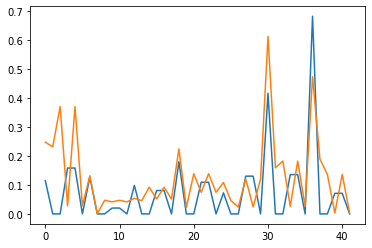

In [589]:
#eval
error_ls = np.array(error_ls).reshape((-1,))
print(np.sum(np.where(error_ls<.5,1,0))/len(error_ls),np.sum(np.where(error_ls<.01,1,0))/len(error_ls))
plt.plot(np.array(error_ls).reshape((-1,)))
wp_error_ls = np.array(wp_error_ls).reshape((-1,))
print(np.sum(np.where(np.abs(wp_error_ls)<1,1,0))/len(wp_error_ls),np.sum(np.where(np.abs(wp_error_ls)<2,1,0))/len(wp_error_ls))
plt.plot(np.array(wp_error_ls).reshape((-1,)))

In [313]:
steps = np.array([2, 1, 1, 2, 1, 1]).reshape((3,2))
weights = [1,1,1]
D,wp1 = lb.sequence.dtw(C=cost_matrix, step_sizes_sigma=steps, weights_mul=weights, subseq=True, backtrack=True)
wp1 = np.sort(wp1,axis=0)
wp1[:,1]+=est_orch_start_chroma_frame

In [448]:
# input time index should match wp
input_time_index/512, (input_time_index[0]-wp[0,1]*512)/sr, (input_time_index[-1]-wp[-1,1]*512)/sr

(array([664.02734375, 664.02734375, 699.59960938]),
 -6.245532879818594,
 -6.232244897959184)

In [449]:
wp,wp1

(array([[  0, 933],
        [  2, 934],
        [  4, 935],
        [  6, 936],
        [  8, 937],
        [  9, 939],
        [ 10, 941],
        [ 11, 942],
        [ 13, 943],
        [ 15, 944],
        [ 17, 945],
        [ 18, 947],
        [ 19, 949],
        [ 21, 950],
        [ 23, 951],
        [ 24, 953],
        [ 25, 955],
        [ 26, 957],
        [ 27, 959],
        [ 28, 960],
        [ 30, 961],
        [ 32, 962],
        [ 34, 963],
        [ 36, 964],
        [ 38, 965],
        [ 40, 966],
        [ 41, 967],
        [ 43, 968]]),
 array([[  0, 589],
        [  2, 590],
        [  4, 591],
        [  5, 592],
        [  7, 593],
        [  9, 594],
        [ 11, 595],
        [ 13, 596],
        [ 15, 597],
        [ 17, 598],
        [ 19, 599],
        [ 21, 600],
        [ 23, 601],
        [ 25, 602],
        [ 27, 603],
        [ 29, 604],
        [ 31, 605],
        [ 33, 606],
        [ 35, 607],
        [ 37, 608],
        [ 39, 609],
        [ 41, 610]

In [316]:
output_time_sec, solo_query_sec

(array([15.41873016, 16.24471655]), array([6.34347695, 7.34459562]))

In [317]:
# if output has similar interval as input,then we are not streching correctly
output_time_sec - time_function[int(orch_start_time*sr)]/sr, solo_query_sec-solo_start_time, input_time_index/sr-orch_start_time

(array([0.86063492, 1.68662132]),
 array([0.99931973, 2.0004384 ]),
 array([0.86060469, 1.68659108]))

In [318]:
conclusion: matched to the wrong thing. 

SyntaxError: invalid syntax (<ipython-input-318-28174e8b546c>, line 1)

In [319]:
approach:
requirement: provide approximate location for segments  within 1 (or variable) seconds 
solution: modify the cost matrix, add penality when far away from estimated location. 
    keep track of how long we pass through, and use that to modify cost matrix
    oh, maybe we need custom matrix for early stopping, or 0 weight transition. former is better


SyntaxError: invalid syntax (<ipython-input-319-0ec19d4d5add>, line 1)

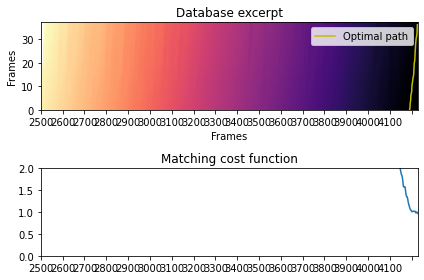

In [562]:
>>> plt.subplot(2, 1, 1)
>>> lb.display.specshow(D, x_axis='frames', y_axis='frames')
>>> plt.title('Database excerpt')
>>> plt.plot(wp[:, 1]-est_orch_start_chroma_frame, wp[:, 0], label='Optimal path', color='y')
>>> plt.xticks([i for i in range(0,D.shape[1],100)],[i for i in range(est_orch_start_chroma_frame//100*100,\
                                                                     est_orch_end_chroma_frame//100*100,100)])
>>> plt.legend()
>>> plt.subplot(2, 1, 2)
>>> plt.plot(D[-1, :] / wp.shape[0])
>>> 
>>> plt.xlim([0, D.shape[1]])
>>> plt.ylim([0, 2])
>>> plt.title('Matching cost function')
>>> plt.xticks([i for i in range(0,D.shape[1],100)],[i for i in range(est_orch_start_chroma_frame//100*100,\
                                                                     est_orch_end_chroma_frame//100*100,100)])
>>> plt.tight_layout()
>>> plt.show()

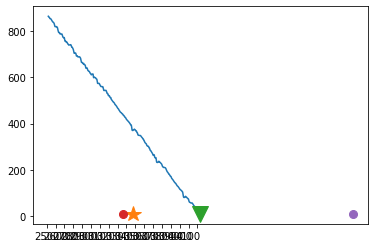

In [563]:
plt.plot(D[-1]),est_orch_start_chroma_frame, input_time_index
plt.xticks([i for i in range(0,D.shape[1],100)],[i for i in range(est_orch_start_chroma_frame//100*100,\
                                                                     est_orch_end_chroma_frame//100*100,100)])
# goal
plt.plot(input_time_index[-1]/512-est_orch_start_chroma_frame,10,marker="*", markersize=16)
# prediction
plt.plot(wp[-1,1]-est_orch_start_chroma_frame,10,marker="v", markersize=16)
plt.plot(D.shape[1]//2,10,marker=".", markersize=16)
input_time_index/512
plt.plot((est_curr_frame),10,marker=".", markersize=16)

In [527]:
est_curr_frame

1371

([<matplotlib.lines.Line2D at 0x7fc442970690>], 1726, 3451)

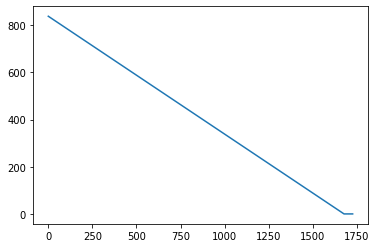

In [567]:
plt.plot(D[0]),c,est_curr_frame

In [436]:
wp,c,est_curr_frame, D.shape[1]

(array([[  0, 828]]), 828, 828, 1475)

In [439]:
c

828

In [440]:
D[-1][828]

0.0

In [256]:
def evalBeatRealTime(sr=22050):
    error_ls = []
    
    print("start preparation")
    orch_piece, solo_piece  = get_piece()
    orch_seg_player_time, solo_seg_player_time= all_annotation_data(orch_piece, solo_piece)
    diff_seg_player = []
    
    input_num_beat = 4
    
    piece_id = 0
    count=0
    correct = 0
    tolerance = .5
    print("complete preparation")
    
    for piece_id in range(len(orch_seg_player_time)):
        print("new piece",piece_id)
        for seg_id in range(len(orch_seg_player_time[piece_id])):
            print("new seg",seg_id)
            diff_o_s_player = []
            for o_player_id in range(len(orch_seg_player_time[piece_id][seg_id])):
                
                
                orch_piece_id = orch_piece[piece_id][o_player_id]
                orch_audio = audioFiles[orch_piece_id]
                orch_time = solo_seg_player_time[piece_id][seg_id][o_player_id]
                
                
                for s_player_id in range(len(solo_seg_player_time[piece_id][seg_id])):
                    
                    
                    solo_piece_id = solo_piece[piece_id][o_player_id]
                    
                    
                    solo_audio  = audioFiles[solo_piece_id][seg_id]
                    
                    stored_info = dict()
                    orchestra_chroma = getChromaFeatures(orch_audio)
                    stored_info["orchestra_chroma"]=orchestra_chroma 
                    stored_info['orchestra_audio'] = orch_audio
                    stored_info['prior'] = []
                    stored_info["last end"] = 0
                    solo_time = solo_seg_player_time[piece_id][seg_id][s_player_id]
                    ground_truth_baseline_sec = solo_time[0]
                    
                    print("seg",seg_id,"player combo",o_player_id,s_player_id,len(solo_time)-input_num_beat-1)
                    
                    for i in range(len(solo_time)-input_num_beat-1):
                        
                        
                        check_nan_ls = [solo_time[i+j] for j in range(input_num_beat+1)]
                        check_nan_ls.extend([orch_time[i+j] for j in range(input_num_beat+1)])
                        check_nan = [math.isnan(num) for num in check_nan_ls]
                        if True in check_nan:
                            #print("skip")
                            continue
                        
                        audio_input = solo_audio[int(solo_time[i]*sr):int(solo_time[i+input_num_beat]*sr)+1]
                        if len(audio_input)<1:
                            #print("skip")
                            continue
                        start_time = time.time()
                        audio_output, time_function_output, stored_info = realTimeAccompaniment(audio_input,stored_info,True, False)
                        
                        time_offset = time.time()-start_time
                        
                        input_sec = [orch_time[i+j]-orch_time[0] for j in range(input_num_beat)]
                        
                        input_index = [int(j*sr) for j in input_sec]
                        
                        output_index = np.array([time_function_output[j] for j in input_index])
                        
                        output_sec = output_index/sr#+time_offset
                        
                        if i == 0:
                            output_baseline_sec = output_sec[0]
                        
                        
                        output_sec = output_sec - output_baseline_sec
                        
                        ground_truth_sec = np.array([solo_time[i+j] for j in range(input_num_beat)])
                        
                        ground_truth_sec = ground_truth_sec - ground_truth_baseline_sec
                        
                        error = ground_truth_sec-output_sec
                        
                        error_ls.append(error)
                        
                        count+=4
                        correct += np.sum(np.where(np.abs(error)<tolerance,1,0))
                        if i%20 == 0:
                            print("seg",seg_id,"player combo",o_player_id,s_player_id,i)
                            print(error)
                            print("     ",input_sec,output_sec,ground_truth_sec, time_offset)
                            print()
                        break
                    break
                break
            break

    clean_error_ls =np.zeros(len(error_ls)*input_num_beat)
    for index, i in enumerate(error_ls):
        clean_error_ls[index*input_num_beat:(index+1)*input_num_beat] = i
    return clean_error_ls

In [257]:
clean_error_ls = evalBeatRealTime()

start preparation


NameError: name 'all_annotation_data' is not defined

In [198]:
np.sum(clean_error_ls)/len(clean_error_ls)

NameError: name 'clean_error_ls' is not defined

In [36]:
def realTimeAccompanimentWPrior(new_input,stored_info,evaluate, sim):
    #prior = stored_info['prior']
    orchestra_chroma = stored_info['orchestra_chroma']
    '''
    audio_input = np.zeros((len(new_input)+len(prior)))
    if len(prior)>0:
        audio_input[:len(prior)]=prior
        audio_input[len(prior):]=new_input
    else:
        audio_input=new_input
    '''
    prior = stored_info['prior']
    if len(prior)!=0:
        input_with_prior = np.zeros(len(prior)+len(new_input))
        input_with_prior[:len(prior)] = prior
        input_with_prior[len(prior):] = new_input
    else:
        input_with_prior = new_input
    stored_info['prior'] = []
    orchestra_audio = stored_info['orchestra_audio']
    input_chroma = getChromaFeatures(input_with_prior)
    cost_matrix = getCostMatrix(input_chroma, orchestra_chroma)
    D,wp = subsequencialDTW(cost_matrix)
    wp = np.sort(wp,axis=0)
    tf, itf, audio_output = [], [], []
    if evaluate:
        tf = group_time_function([wp],len(orchestra_audio))
    if sim:
        itf = inverse_time_function(wp)
        audio_output = TSM_Import.phase_vocoder(orchestra_audio, (itf).astype(int))
    
    #stored_info['prior'].append(new_input)
    return audio_output, tf, stored_info

In [149]:
soloist = audioFiles["p1s_perf12"][0][:10*sr]
soloist_long = [soloist[int(i//2)] for i in range(int(len(soloist[:5*sr])*2))]
print(len(soloist_long))
extension = [soloist[int(i)+5*sr] for i in range(len(soloist[5*sr:]))]
print(len(extension))
soloist_long.extend(extension)
print(len(soloist_long))
soloist_long = np.array(soloist_long)
soloist_long
#new_soloist = [.001 for i in range(3*sr)]
#new_soloist.extend(soloist)
#soloist = new_soloist
ipd.Audio(soloist,rate=sr)

220500
110250
330750


array([ 0.00320435,  0.00320435,  0.00234985, ..., -0.06347656,
       -0.03170776, -0.00238037], dtype=float32)